## global stuff

### imports

In [ ]:
import re
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

import os, sys
sys.path.append("../../")

from kernels import ReluNTK
from feature_decomp import Monomial
from tools import get_log_log_linear_fit
from utils import ensure_torch
from misc import rcsetup
from FileManager import FileManager
from ExptTrace import ExptTrace

In [788]:
rcsetup()

In [ ]:
colors = ['xkcd:black', 'xkcd:red', 'xkcd:orange yellow', 'xkcd:green', 'xkcd:blue', 'xkcd:purple']
# colors = ['xkcd:black', 'xkcd:lilac', 'xkcd:blue', 'xkcd:green', 'xkcd:orange yellow', 'xkcd:red']
#['xkcd:purple', 'xkcd:raspberry', 'xkcd:cerulean', 'xkcd:tangerine', 'xkcd:black', 'xkcd:forest green', 'xkcd:crimson']
markers = ['x', 's', 'o', '^', 'D', '*', 'v', 'p', 'h']

### plotting

In [ ]:
def make_triangle(ax, x=7, y0=5, dlogx=1.3, slope=0.5):
    #triangle        
    dlogy = slope * dlogx 
    x1 = x * 10**dlogx
    y1 = y0 * 10**dlogy
    dx = x1 - x
    dy = y1 - y0
    x_coords = [x, x1, x1]
    y_coords = [y0, y0, y1]
    ax.plot(x_coords, y_coords, 'k-', linewidth=0.5)
    ax.plot([x, x1], [y0, y1], 'k-', linewidth=0.5)  
    ax.text(x+dx*1.1, y0+dy*(np.log10(2)), r'$1/2$', 
            va='center', ha='left', fontsize=13, fontweight="light")

In [ ]:
from matplotlib.lines import Line2D

def make_color_handles(colors, max_handle=None):
        labels = ["constant", "linear", "quadratic", "cubic", "quartic"]

        # Determine the last included index (inclusive)
        if max_handle is None:
            last = min(len(labels) - 1, len(colors) - 1)
        else:
            if max_handle < 0:
                return []  # nothing to show
            last = min(max_handle, len(labels) - 1, len(colors) - 1)

        pairs = [(lbl, c) for lbl, c in zip(labels[:last+1], colors[:last+1])]

        color_handles = [
            Line2D([0], [0], marker='o', linestyle='none',
                markerfacecolor=c, markeredgecolor='black', markersize=10,
                label=lbl)
            for lbl, c in pairs
        ]
        return color_handles

def add_degree_and_shape_legends(ax, color_handles, colors=colors, legloc = "upper left"):

    # shape_handles = [
    #     Line2D([0], [0], marker=m, linestyle='none',
    #            markerfacecolor='white', markeredgecolor='black', markersize=9,
    #            label=lbl)
    #     for m, lbl in [
    #         ('x', 'constant mode'),
    #         ('s', 'no repeated indices'),
    #         ('o', '1 repeated index'),
    #         ('^', '2 repeated indices'),
    #         ('D', '3 repeated indices'),
    #     ]
    # ]

    # One legend, two columns, top-right
    all_handles = color_handles# + shape_handles
    ax.legend(
        handles=all_handles,
        ncol=1,#2,
        loc=legloc,
        frameon=False,
        columnspacing=1.2,
        handletextpad=0.6,
        # title="color = degree, shape = index pattern"
    )

In [ ]:
import matplotlib.colors as mcolors
# colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
def lighten(color, amount=0.5):
    rgb = mcolors.to_rgb(mcolors.XKCD_COLORS.get(color, color))
    if amount >= 0:
        new_rgb = tuple(c + (1 - c) * amount for c in rgb)
    else:
        new_rgb = tuple(c * (1 + amount) for c in rgb)
    # Clip values to [0, 1]
    new_rgb = tuple(min(max(x, 0), 1) for x in new_rgb)
    return new_rgb

In [821]:
def plot_ttl_across_max_deg(fig, axes, timekeys_mean, timekeys_std, targets, monomials, eigvals, errorbar_on=True, colors=None, s=6): #fra_eigvals

    target_monomials = targets
    if type(target_monomials[0]) == str:
        target_monomials = np.array([Monomial.from_repr(target_monomial) for target_monomial in target_monomials])
    target_degrees = np.array([target_monomial.degree() for target_monomial in target_monomials])
    target_max_degrees = np.array([target_monomial.max_degree() for target_monomial in target_monomials])
    degrees = np.array([monomial.degree() if monomial in target_monomials else 0 for monomial in monomials], dtype=int)
    max_degrees = np.array([monomial.max_degree() if monomial in target_monomials else 0 for monomial in monomials], dtype=int)


    def _plot_within_order(ax, order=0, opacity=0.5):
        degmaxlocs = torch.tensor(np.where(max_degrees == order)[0])
        degtargetmaxlocs = torch.tensor(np.where(target_max_degrees == order)[0])

        xaxis = (eigvals[degmaxlocs.long()].cpu())**(-1.)
        ys = ensure_torch(timekeys_mean)
        yerr = ensure_torch(timekeys_std)
        slope, intercept = get_log_log_linear_fit(xaxis, ys[degtargetmaxlocs.long()])
        inside_degrees=degrees[degmaxlocs]

        for deg in np.unique(inside_degrees):
            idxs = (inside_degrees == deg)
            if errorbar_on:
                ax.errorbar((eigvals.cpu()[degmaxlocs][idxs])**(-1), timekeys_mean[degtargetmaxlocs][idxs],
                            yerr=yerr[degtargetmaxlocs][idxs],
                            color=colors[deg%7], alpha=opacity, fmt=markers[order], s=s)
            else:
                ax.scatter((eigvals.cpu()[degmaxlocs][idxs])**(-1), timekeys_mean[degtargetmaxlocs][idxs], marker=markers[order],
                        color=colors[deg%7], alpha=opacity, s=s)
        ax.set_title(f"Max Degree {order}")
        ax.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(TTL) = {slope:.2f}*$\\log(\\lambda_{{HEA}}^{{-1}})$+{intercept:.1f}")

    flatax = np.ravel(axes)
    for i, ax in enumerate(flatax, start=1):  # axes[0] -> i=1
        _plot_within_order(ax, order=i)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()

def plot_ttl_across_deg(fig, axes, timekeys_mean, timekeys_std, targets, monomials, eigvals, errorbar_on=True):
    """
    Panels are grouped by *degree >= 1*. The degree-1 panel also overlays degree-0 points.
    Marker encodes max_degree; color encodes the degree whose panel you're in.
    Only the fitted line appears in the legend (no scatter/errorbar entries).
    """
    # Normalize targets -> Monomial objects
    target_monomials = targets
    if isinstance(target_monomials[0], str):
        target_monomials = np.array([Monomial.from_repr(t) for t in target_monomials])
    else:
        target_monomials = np.array(target_monomials)

    # Degrees/max-degrees for targets (index space of timekeys_* arrays)
    target_degrees      = np.array([m.degree()      for m in target_monomials], dtype=int)
    target_max_degrees  = np.array([m.max_degree()  for m in target_monomials], dtype=int)

    # Degrees/max-degrees aligned to full 'monomials' list; 0 for non-targets
    degrees     = np.array([m.degree()     if m in target_monomials else 0 for m in monomials], dtype=int)
    max_degrees = np.array([m.max_degree() if m in target_monomials else 0 for m in monomials], dtype=int)

    def _plot_degree(ax, deg, opacity=0.5, overlay_deg0=False):
        # --- Main (deg) data ---
        deglocs       = torch.tensor(np.where(degrees == deg)[0])                  # monomials/eigvals indices
        degtargetlocs = torch.tensor(np.where(target_degrees == deg)[0])           # targets/timekeys indices

        if deglocs.numel() == 0 or degtargetlocs.numel() == 0:
            ax.set_title(f"Degree {deg} (no data)")
            return

        xaxis = (eigvals[deglocs.long()].cpu())**(-1.0)
        ys    = ensure_torch(timekeys_mean)[degtargetlocs.long()]
        yerr  = ensure_torch(timekeys_std)[degtargetlocs.long()]

        n = min(len(xaxis), len(ys))
        xaxis, ys, yerr = xaxis[:n], ys[:n], yerr[:n]

        slope, intercept = get_log_log_linear_fit_positive(xaxis, ys)

        # Scatter/errorbar by max_degree (no legend labels)
        inside_max_degrees = max_degrees[deglocs][:n]
        for mdeg in np.unique(inside_max_degrees):
            mask = (inside_max_degrees == mdeg)
            if not np.any(mask):
                continue
            marker = markers[mdeg % len(markers)]
            if errorbar_on:
                ax.errorbar(xaxis[mask], ys[mask], yerr=yerr[mask],
                            color=colors[deg % len(colors)], alpha=opacity, fmt=marker, label="_nolegend_")
            else:
                ax.scatter(xaxis[mask], ys[mask], alpha=opacity, marker=marker,
                           color=colors[deg % len(colors)], label="_nolegend_")

        # Optional: overlay degree 0 points on the degree 1 panel (no legend; does not affect fit)
        if overlay_deg0:
            d0locs       = torch.tensor(np.where(degrees == 0)[0])
            d0targetlocs = torch.tensor(np.where(target_degrees == 0)[0])
            if d0locs.numel() > 0 and d0targetlocs.numel() > 0:
                x0 = (eigvals[d0locs.long()].cpu())**(-1.0)
                y0 = ensure_torch(timekeys_mean)[d0targetlocs.long()]
                e0 = ensure_torch(timekeys_std)[d0targetlocs.long()]
                m0 = min(len(x0), len(y0))
                x0, y0, e0 = x0[:m0], y0[:m0], e0[:m0]
                # Use a distinct, faint look; still no legend entry
                if errorbar_on:
                    ax.errorbar(x0, y0, yerr=e0, fmt=markers[0 % len(markers)],
                                alpha=0.35, color=colors[0 % len(colors)], label="_nolegend_")
                else:
                    ax.scatter(x0, y0, marker=markers[0 % len(markers)],
                               alpha=0.35, color=colors[0 % len(colors)], label="_nolegend_")

        # Only the regression line gets a legend label
        (line_handle,) = ax.plot(xaxis, (10.0**intercept) * (xaxis**slope), color='k',
                                 label=f"log(TTL) = {slope:.2f}·$\\log(\\lambda_{{HEA}}^{{-1}})$ + {intercept:.1f}")
        ax.set_title(f"Degree {deg}")
        ax.set_xscale('log')
        ax.set_yscale('log')
        # Legend shows only the line because all scatters had label "_nolegend_"
        ax.legend(handles=[line_handle])

    # Panels: start at degree = 1 (no separate degree-0 panel)
    flatax = np.ravel(axes)
    for i, ax in enumerate(flatax, start=1):  # axes[0] -> degree 1, axes[1] -> degree 2, ...
        overlay = (i == 1)  # overlay deg 0 only on degree 1 panel
        _plot_degree(ax, deg=i, overlay_deg0=overlay)


def get_log_log_linear_fit(x, y, fixed_slope: float | None = None):
    """
    Fit log10(y) = slope * log10(x) + intercept.
    If fixed_slope is provided, only estimate the intercept.
    """
    xt = ensure_torch(x)
    yt = ensure_torch(y)

    log_x = torch.log10(xt).reshape(-1, 1)
    z = torch.log10(yt).reshape(-1, 1)

    if fixed_slope is not None:
        m = float(fixed_slope)
        b = float((z - m * log_x).mean())
        return m, b

    A = torch.column_stack((log_x, torch.ones_like(log_x)))
    sol = torch.linalg.lstsq(A, z).solution.squeeze()  # [slope, intercept]
    return float(sol[0]), float(sol[1])

In [ ]:
def plot_time_to_learn_eigenvalue(eigvals, timekeys, target_monomials, scale='log', **kwargs):
    if type(target_monomials[0]) == str:
        target_monomials = np.array([Monomial.from_repr(target_monomial) for target_monomial in target_monomials])
    degrees = np.array([target_monomial.degree() for target_monomial in target_monomials])
    colors = kwargs.get("colors", ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"])
    #marker stuff
    markers = ['x', 's', 'o', '^', 'D', '*', 'v', 'p', 'h']
    max_degrees  = np.array([target_monomial.max_degree() for target_monomial in target_monomials])
    max_deg = int(np.asarray(max_degrees).max())
    uniq_md = np.arange(max_deg + 1)
    md2marker   = {md: markers[i % len(markers)] for i, md in enumerate(uniq_md)}

    pairs = np.unique(np.stack([degrees, max_degrees], axis=1), axis=0)

    for degree, md in pairs:
        idxs = np.flatnonzero((degrees == degree) & (max_degrees == md))
        if kwargs.get("errorbar", False):
            plt.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], color=colors[degree%7], alpha=kwargs.get("alpha", 1), fmt=md2marker[md])
        else:
            plt.scatter((eigvals[idxs])**(-1), timekeys[idxs], marker=md2marker[md], color=colors[degree%7], alpha=kwargs.get("alpha", 1))
    plt.xscale(scale)
    plt.yscale(scale)
    plt.xlabel(f"HEA Eigval $\\lambda^{{-1}}$")
    plt.ylabel(f"Time to learn "+kwargs.get("breakpoint", ""))
    # plt.title(f"Time to learn vs FRA Eigval")

def plot_time_to_learn_eigenvalue_lightened(eigvals, timekeys, target_monomials, scale='log', lightenamount=0, **kwargs):
    if type(target_monomials[0]) == str:
        target_monomials = np.array([Monomial.from_repr(target_monomial) for target_monomial in target_monomials])
    degrees = np.array([target_monomial.degree() for target_monomial in target_monomials])
    colors = kwargs.get("colors", ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"])
    #marker stuff
    markers = ['x', 's', 'o', '^', 'D', '*', 'v', 'p', 'h']
    max_degrees  = np.array([target_monomial.max_degree() for target_monomial in target_monomials])
    max_deg = int(np.asarray(max_degrees).max())
    uniq_md = np.arange(max_deg + 1)
    md2marker   = {md: markers[i % len(markers)] for i, md in enumerate(uniq_md)}

    pairs = np.unique(np.stack([degrees, max_degrees], axis=1), axis=0)

    for degree, md in pairs:
        idxs = np.flatnonzero((degrees == degree) & (max_degrees == md))
        if kwargs.get("errorbar", False):
            plt.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], color=lighten(colors[degree%7], amount=lightenamount), alpha=kwargs.get("alpha", 1), fmt=md2marker[md])
        else:
            plt.scatter((eigvals[idxs])**(-1), timekeys[idxs], marker=md2marker[md], color=lighten(colors[degree%7], amount=lightenamount), alpha=kwargs.get("alpha", 1))
    plt.xscale(scale)
    plt.yscale(scale)
    # plt.title(f"Time to learn vs FRA Eigval")

def plot_time_to_learn_eigenvalue_lightened_ax(ax, eigvals, timekeys, target_monomials, scale='log', lightenamount=0, **kwargs):
    if type(target_monomials[0]) == str:
        target_monomials = np.array([Monomial.from_repr(target_monomial) for target_monomial in target_monomials])
    degrees = np.array([target_monomial.degree() for target_monomial in target_monomials])
    colors = kwargs.get("colors", ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"])
    #marker stuff
    markers = ['x', 's', 'o', '^', 'D', '*', 'v', 'p', 'h']
    max_degrees  = np.array([target_monomial.max_degree() for target_monomial in target_monomials])
    max_deg = int(np.asarray(max_degrees).max())
    uniq_md = np.arange(max_deg + 1)
    md2marker   = {md: markers[i % len(markers)] for i, md in enumerate(uniq_md)}

    pairs = np.unique(np.stack([degrees, max_degrees], axis=1), axis=0)

    for degree, md in pairs:
        idxs = np.flatnonzero((degrees == degree) & (max_degrees == md))
        if kwargs.get("errorbar", False):#fmt=md2marker[md]
            ax.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], color=lighten(colors[degree%7], amount=lightenamount),
                        alpha=kwargs.get("alpha", 1), fmt=markers[kwargs.get('marker_index', 2)], ms=kwargs.get("s"))
        else:#md2marker[md]
            ax.scatter((eigvals[idxs])**(-1), timekeys[idxs], color=lighten(colors[degree%7], amount=lightenamount),
                       alpha=kwargs.get("alpha", 1), marker=markers[kwargs.get('marker_index', 2)], ms=kwargs.get("s"))
    ax.set_xscale(scale)
    ax.set_yscale(scale)
    # plt.title(f"Time to learn vs FRA Eigval")

def plot_time_to_learn_eigenvalue_ax(ax, eigvals, timekeys, target_monomials, scale='log', **kwargs):
    if type(target_monomials[0]) == str:
        target_monomials = np.array([Monomial.from_repr(target_monomial) for target_monomial in target_monomials])
    degrees = np.array([target_monomial.degree() for target_monomial in target_monomials])
    colors = kwargs.get("colors", ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"])
    #marker stuff
    markers = ['x', 's', 'o', '^', 'D', '*', 'v', 'p', 'h']
    max_degrees  = np.array([target_monomial.max_degree() for target_monomial in target_monomials])
    max_deg = int(np.asarray(max_degrees).max())
    uniq_md = np.arange(max_deg + 1)
    md2marker   = {md: markers[i % len(markers)] for i, md in enumerate(uniq_md)}

    pairs = np.unique(np.stack([degrees, max_degrees], axis=1), axis=0)

    for degree, md in pairs:
        idxs = np.flatnonzero((degrees == degree) & (max_degrees == md))
        if kwargs.get("errorbar", False):
            ax.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], color=colors[degree%7], alpha=kwargs.get("alpha", 1), fmt=md2marker[md])
        else:
            ax.scatter((eigvals[idxs])**(-1), timekeys[idxs], marker=md2marker[md], color=colors[degree%7], alpha=kwargs.get("alpha", 1))
    ax.set_xscale(scale)
    ax.set_yscale(scale)
    # plt.title(f"Time to learn vs FRA Eigval")

def plot_time_to_learn_eigenvalue_ax(ax, eigvals, timekeys, target_monomials, scale='log', **kwargs):
    if type(target_monomials[0]) == str:
        target_monomials = np.array([Monomial.from_repr(target_monomial) for target_monomial in target_monomials])
    degrees = np.array([target_monomial.degree() for target_monomial in target_monomials])
    colors = kwargs.get("colors", ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"])
    #marker stuff
    markers = ['x', 's', 'o', '^', 'D', '*', 'v', 'p', 'h']
    max_degrees  = np.array([target_monomial.max_degree() for target_monomial in target_monomials])
    max_deg = int(np.asarray(max_degrees).max())
    uniq_md = np.arange(max_deg + 1)
    md2marker   = {md: markers[i % len(markers)] for i, md in enumerate(uniq_md)}

    pairs = np.unique(np.stack([degrees, max_degrees], axis=1), axis=0)

    for degree, md in pairs:
        idxs = np.flatnonzero((degrees == degree) & (max_degrees == md))
        if kwargs.get("errorbar", False):
            ax.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], color=colors[degree%7], alpha=kwargs.get("alpha", 1), fmt=md2marker[md])
        else:
            ax.scatter((eigvals[idxs])**(-1), timekeys[idxs], marker=md2marker[md], color=colors[degree%7], alpha=kwargs.get("alpha", 1))
    ax.set_xscale(scale)
    ax.set_yscale(scale)
    # plt.title(f"Time to learn vs FRA Eigval")

In [ ]:
def _to_tuple(x):
    if x is None: return None
    return tuple(x) if isinstance(x, (list, tuple)) else (x,)

def nanvar(x: torch.Tensor, axis=None, correction: int = 1, keepdim: bool = False):
    if not torch.is_floating_point(x):
        x = x.float()
    dims = _to_tuple(axis)
    mask = ~torch.isnan(x)

    if dims is None:
        cnt = mask.sum()
        if cnt == 0 or (cnt - correction) <= 0:
            return torch.tensor(float('nan'), dtype=x.dtype, device=x.device)
        s = torch.where(mask, x, torch.zeros_like(x)).sum()
        m = s / cnt
        sq = torch.where(mask, (x - m) ** 2, torch.zeros_like(x)).sum()
        return sq / (cnt - correction)

    # reduce over multiple dims at once
    cnt = mask.sum(dim=dims, keepdim=True)
    s   = torch.where(mask, x, torch.zeros_like(x)).sum(dim=dims, keepdim=True)
    m   = s / cnt.clamp(min=1)
    sq  = torch.where(mask, (x - m) ** 2, torch.zeros_like(x)).sum(dim=dims, keepdim=True)

    dof = (cnt - correction).clamp(min=0)
    out = sq / dof.clamp(min=1)
    out = torch.where(dof > 0, out, torch.full_like(out, float('nan')))

    if keepdim:
        return out
    # squeeze all reduced dims
    for d in sorted(dims, reverse=True):
        out = out.squeeze(d)
    return out

def nanstd(x: torch.Tensor, dim=None, correction: int = 1, keepdim: bool = False):
    return nanvar(x, dim=dim, correction=correction, keepdim=keepdim).sqrt()


### load results grabbing

In [ ]:
from collections import OrderedDict

RUN_SPLIT_RE = re.compile(r'(?=Runs:)')                 # keep "Runs:" on each split
TIMEKEY_RE   = re.compile(r'timekey\s*\[([^\]]+)\]')
TARGET_RE    = re.compile(r'target=(.*?)(?:\s*\||\])')
TRIAL_RE     = re.compile(r'trial=(\d+)')

def _parse_one(chunk: str):
    """Parse one 'Runs:' chunk -> (target:str, trial:int, (t0:int, t1:int)) or None."""
    tg = TARGET_RE.search(chunk)
    tr = TRIAL_RE.search(chunk)
    tk = TIMEKEY_RE.search(chunk)
    if not (tg and tr and tk):
        return None

    # target string as-is (e.g., "$x_{0}^2$")
    target = tg.group(1).strip()

    # trial integer
    trial = int(tr.group(1))

    # parse first two integers inside timekey [...]
    nums = [int(x) for x in re.findall(r'-?\d+', tk.group(1))]
    if len(nums) < 2:
        return None
    t0, t1 = nums[0], nums[1]
    return target, trial, (t0, t1)

def _parse_timekeys_from_text(text: str):
    """
    Returns:
      timekeys: np.ndarray with shape [2, num_targets, num_trials]
      targets:  np.ndarray with shape [num_targets] (dtype=object)
      trial_count: int (the global num_trials used)
      index_map: dict {target: index_in_targets}
    Missing (target, trial) entries are filled with NaN.
    """
    records = []
    for chunk in RUN_SPLIT_RE.split(text):
        chunk = chunk.strip()
        if not chunk:
            continue
        parsed = _parse_one(chunk)
        if parsed:
            records.append(parsed)

    # order targets by first appearance
    target_order = OrderedDict()
    for target, _, _ in records:
        if target not in target_order:
            target_order[target] = len(target_order)

    if not target_order:
        # nothing parsed; return empty shapes
        return (np.zeros((2, 0, 0), dtype=float),
                np.array([], dtype=object),
                0,
                {})

    # compute a global num_trials so we can build a rectangular tensor
    # (use max observed trial index + 1)
    max_trial = -1
    for _, trial, _ in records:
        if trial > max_trial:
            max_trial = trial
    num_targets = len(target_order)
    num_trials = max_trial + 1 if max_trial >= 0 else 0

    # initialize with NaNs; fill as we go
    timekeys = np.full((2, num_targets, num_trials), np.nan, dtype=float)

    # fill using "last seen wins" for duplicate (target, trial)
    for target, trial, (t0, t1) in records:
        ti = target_order[target]
        if 0 <= trial < num_trials:
            timekeys[0, ti, trial] = t0
            timekeys[1, ti, trial] = t1

    targets = np.array(list(target_order.keys()), dtype=object)
    return timekeys, targets, num_trials, dict(target_order)


def _pick_axis(var_names, *candidates):
    for name in candidates:
        if name in var_names:
            return name
    return None


def _normalize_outcome(outcome):
    arr = np.asarray(outcome)
    if arr.ndim == 0:
        arr = arr.reshape(1)
    return arr


def _parse_timekeys_from_expt_result(result, *, n=None, target_var="target", n_var=None, trial_var="trial"):
    """
    Parse timekeys from a job-iterator-style result dict or ExptTrace instance.

    Args:
        result: dict from FileManager.load("result.pickle") or an ExptTrace.
        n: optional ntrain value to slice if the trace includes an n axis.
    """
    if isinstance(result, ExptTrace):
        et_timekeys = result
    else:
        if isinstance(result, dict):
            timekeys_blob = result.get("timekeys", result)
        else:
            timekeys_blob = result
        if isinstance(timekeys_blob, ExptTrace):
            et_timekeys = timekeys_blob
        else:
            et_timekeys = ExptTrace.deserialize(timekeys_blob)

    var_names = list(et_timekeys.var_names)

    if target_var not in var_names:
        target_var = _pick_axis(var_names, "target", "targets", "monomial", "monomials", "tstr")
    if trial_var not in var_names:
        trial_var = _pick_axis(var_names, "trial", "trials", "seed", "run")
    if target_var is None or trial_var is None:
        raise ValueError(f"Could not identify target/trial axes in {var_names}")

    if n_var is None:
        n_var = _pick_axis(var_names, "ntrain", "n", "n_samples", "nsamples")

    n_idx = None
    if n_var in var_names:
        n_idx = var_names.index(n_var)
        if n is None:
            n_vals = et_timekeys.get_axis(n_var)
            if len(n_vals) == 1:
                n = n_vals[0]
            else:
                raise ValueError(f"Multiple {n_var} values present; pass n=... to select one.")

    t_idx = var_names.index(target_var)
    trial_idx = var_names.index(trial_var)

    records = []
    for config, outcome in et_timekeys._config2outcome.items():
        if n_idx is not None and n is not None and config[n_idx] != n:
            continue
        records.append((config[t_idx], config[trial_idx], outcome))

    # order targets by first appearance
    target_order = OrderedDict()
    for target, _, _ in records:
        if target not in target_order:
            target_order[target] = len(target_order)

    if not target_order:
        return (np.zeros((0, 0, 0), dtype=float),
                np.array([], dtype=object),
                0,
                {})

    # compute trial axis (prefer numeric, fallback to appearance order)
    numeric_trials = True
    max_trial = -1
    trial_order = OrderedDict()
    for _, trial, _ in records:
        try:
            trial_val = int(trial)
            if trial_val > max_trial:
                max_trial = trial_val
            if trial not in trial_order:
                trial_order[trial] = trial_val
        except (TypeError, ValueError):
            numeric_trials = False
            if trial not in trial_order:
                trial_order[trial] = len(trial_order)

    if numeric_trials:
        num_trials = max_trial + 1 if max_trial >= 0 else 0
        def trial_to_index(t):
            return int(t)
    else:
        # ensure all trials are represented in order of appearance
        for _, trial, _ in records:
            if trial not in trial_order:
                trial_order[trial] = len(trial_order)
        num_trials = len(trial_order)
        def trial_to_index(t):
            return trial_order[t]

    # determine timekey length
    outcome_len = _normalize_outcome(records[0][2]).shape[0] if records else 0
    num_targets = len(target_order)
    timekeys = np.full((outcome_len, num_targets, num_trials), np.nan, dtype=float)

    for target, trial, outcome in records:
        ti = target_order[target]
        tj = trial_to_index(trial)
        if 0 <= tj < num_trials:
            arr = _normalize_outcome(outcome)
            if arr.shape[0] != outcome_len:
                raise ValueError(f"timekeys shape {arr.shape} != expected {(outcome_len,)}")
            timekeys[:, ti, tj] = arr

    targets = np.array(list(target_order.keys()), dtype=object)
    return timekeys, targets, num_trials, dict(target_order)


def parse_timekeys_to_array(text_or_result, *, n=None, target_var="target", n_var=None, trial_var="trial"):
    """
    Returns:
      timekeys: np.ndarray with shape [num_thresholds, num_targets, num_trials]
      targets:  np.ndarray with shape [num_targets] (dtype=object)
      trial_count: int (the global num_trials used)
      index_map: dict {target: index_in_targets}

    If `text_or_result` is a dict/ExptTrace (e.g. FileManager.load("result.pickle")),
    load timekeys from the serialized ExptTrace. Otherwise parse from log text.
    """
    if isinstance(text_or_result, FileManager):
        loaded = text_or_result.load("result.pickle")
        if loaded is None:
            raise FileNotFoundError("result.pickle not found via FileManager")
        return _parse_timekeys_from_expt_result(loaded, n=n, target_var=target_var, n_var=n_var, trial_var=trial_var)

    if isinstance(text_or_result, dict) or isinstance(text_or_result, ExptTrace):
        return _parse_timekeys_from_expt_result(text_or_result, n=n, target_var=target_var, n_var=n_var, trial_var=trial_var)

    return _parse_timekeys_from_text(text_or_result)

In [ ]:
import json

from feature_decomp import Monomial

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

data_eigvals = torch.tensor(load_json("data_eigvals.json"), dtype=torch.float)
hea_eigvals  = torch.tensor(load_json("hea_eigvals.json"), dtype=torch.float)

mon_repr = load_json("monomials.json")  # list of strings like "$x_{0}^2$"
monomials = np.array([Monomial.from_repr(m) for m in mon_repr], dtype=object)

c = {
    0: 0.9423311143775628,
    1: 0.7585548159036320,
    2: 0.3062938307898845,
    3: 0.1837762984739307,
    4: 0.4492309518251639,
    5: 1.3749189737679260,
    6: 5.9352937877506510,
}

raw_eigvals = []
for m, v in zip(monomials, hea_eigvals):
    d = m.degree()
    if d not in c:
        raise ValueError(f"degree {d} not supported (only 0..4)")
    raw_eigvals.append(v / c[d])
raw_eigvals = torch.tensor(raw_eigvals)

## all results

### base

In [ ]:
exptpath = os.getenv("EXPTPATH")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", "mlp-learning", "synthetic")

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)
result = expt_fm.load("result.pickle")
lr_base = 1e-2

### width

In [ ]:
exptpath = os.getenv("EXPTPATH")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", "mlp-width", "synthetic")

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)
result_width = expt_fm.load("result.pickle")
lr_width = 1e-2

### depth

In [ ]:
exptpath = os.getenv("EXPTPATH")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", "mlp-width", "synthetic")

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)
result_depth = expt_fm.load("result.pickle")
lr_depth = 1e-2

### lr

In [ ]:
exptpath = os.getenv("EXPTPATH")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", "mlp-lr", "synthetic")

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)
result_lr = expt_fm.load("result.pickle")
lr_lr = 5e-2

### NTK

In [ ]:
exptpath = os.getenv("EXPTPATH")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", "mlp-ntk", "synthetic")

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)
result_ntk = expt_fm.load("result.pickle")
lr_ntk = 1e-2*(1e-3)**2

### hyper-rich

In [ ]:
exptpath = os.getenv("EXPTPATH")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", "mlp-rich", "synthetic")

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)
result_rich = expt_fm.load("result.pickle")
lr_rich = 1e-2*1e3

### bsz

In [ ]:
exptpath = os.getenv("EXPTPATH")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", "mlp-bsz", "synthetic")

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)
result_bsz = expt_fm.load("result.pickle")
lr_bsz = 1e-2

### data exponent

In [ ]:
exptpath = os.getenv("EXPTPATH")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", "mlp-alpha", "synthetic")

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)
result_alpha = expt_fm.load("result.pickle")
lr_alpha = 1e-2

## base case

In [ ]:
timekeys_base, targets_base, num_trials_base, _ = parse_timekeys_to_array(result)
locs_base = torch.zeros(len(targets_base))

for i, monomial in enumerate(targets_base):
    monomial = Monomial.from_repr(monomial)
    # print(np.where(np.array(monomials) == monomial))
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)):
        break
    # print(loc)
    loc = np.where(np.array(monomials) == monomial)[0][0]
    locs_base[i] = loc

In [ ]:
tags_base = [{}, {1:1}, {5:1}, {100:1}, {204:1},
        {0:2}, {0:1,2:1}, {2:1, 3:1}, {1:1,10:1}, #{1:1,40:1},
        {1:3}, {0:1, 1:1, 2:1}, {3:1, 5:2},
        {0:4}, {0:1, 1:1, 2:1, 3:1}]
noteable_targets_base = list(map(Monomial, tags_base))
t2 = list(map(Monomial.from_repr, targets_base))
noteable_locs_base = torch.zeros(len(noteable_targets_base))
noteable_y_base = torch.zeros(len(noteable_targets_base))

for i, monomial in enumerate(noteable_targets_base):
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)):
        break
    if monomial in monomials:
        loc = np.where(np.array(monomials) == monomial)[0][0]
        noteable_locs_base[i] = loc
    if monomial in t2:
        loc = np.where(np.array(t2) == monomial)[0][0]
        noteable_y_base[i] = loc
# noteable_targets_base

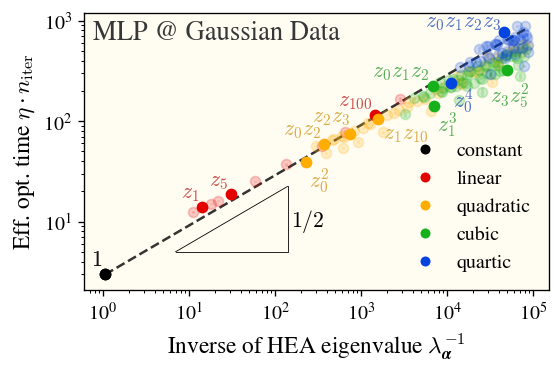

In [794]:
s = 6
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)*lr_base
breakpoints_std = (nanvar(torch.as_tensor(timekeys_base[-1]), axis=-1))**(0.5)*lr_base

xaxis = ((hea_eigvals[locs_base.long()].cpu()))**(-1.)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_base.long()].cpu(), breakpoints_means.cpu(), targets_base,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")

#points
point_locs_base = [3, 3, 3, 3,
        3, 0, 3, 3, 0,
        0, 3, 0,
        0, 3]

for idx, xi, yi in zip(noteable_locs_base, hea_eigvals[noteable_locs_base.long()]**(-1.), breakpoints_means[noteable_y_base.long()]):
    m = Monomial(monomials[idx.int().cpu().numpy()])
    if m in tags_base:
        color = colors[m.degree() % len(colors)]
        ax.scatter(xi, yi, color = color, alpha=1, zorder=10, s=s**2.)
        i = tags_base.index(monomials[idx.int().cpu().numpy()])
        kwargs = {"ha": "left" if point_locs_base[i] < 2 else "right",
                  "va": "bottom" if point_locs_base[i] % 2 == 1 else "top"}
        z = 0.08
        off = (
            z if point_locs_base[i] < 2 else -z,
            z if point_locs_base[i] % 2 == 1 else -z
        )
        if m == Monomial({3:2, 5:1}):
            kwargs["ha"] = "center"
            off = (off[0]+0.28, off[1]+0.04)
        elif m == Monomial({3:1, 5:2}):
            kwargs["ha"] = "center"
            off = (off[0], off[1]-.14)
        elif m == Monomial({2:1, 3:1}):
            kwargs["ha"] = "right"
            off = (off[0]+0.08, off[1]+0.08)
        elif m == Monomial({1:1, 10:1}):
            kwargs["ha"] = "left"
            kwargs["va"] = "top"
            off = (off[0]+.07, off[1]-.04)
        elif m == Monomial({0:1, 1:1, 2:1, 3:1}):
            kwargs["ha"] = "right"
            off = (off[0], off[1]-.08)
        ax.annotate(str(m).replace('x', 'z'), (xi*(1+off[0]), yi*(1+off[1])), fontsize=13,
                    color=lighten(color, -0.2), alpha=0.7, **kwargs)
        

#triangle 
x0, y0 = 7, 5
dlogx = 1.3        
dlogy = 0.5 * dlogx 
x1 = x0 * 10**dlogx
y1 = y0 * 10**dlogy
dx = x1 - x0
dy = y1 - y0
x_coords = [x0, x1, x1]
y_coords = [y0, y0, y1]
ax.plot(x_coords, y_coords, 'k-', linewidth=0.5)
ax.plot([x0, x1], [y0, y1], 'k-', linewidth=0.5)  
ax.text(x0+dx*1.1, y0+dy*(np.log10(2)), r'$1/2$', 
         va='center', ha='left', fontsize=13, fontweight="light")

ax.text(0.02, 0.97, f"MLP @ Gaussian Data", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

color_handles = make_color_handles(colors, max_handle=4, s=s)
all_handles = color_handles
ax.legend(
        handles=all_handles,
        ncol=1,#2,
        loc="lower right",
        frameon=False,
        columnspacing=1.2,
        handletextpad=0.6,   
    )

ax.set_xlabel(r'Inverse of HEA eigenvalue $\lambda_{\boldsymbol{\alpha}}^{-1}$', fontsize=14)
ax.set_ylabel("Eff. opt. time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()

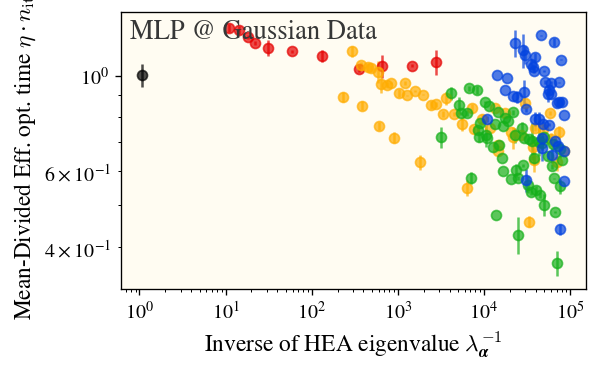

In [806]:
s = 6
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)*lr_base
breakpoints_std = (nanvar(torch.as_tensor(timekeys_base[-1]), axis=-1))**(0.5)*lr_base

xaxis = ((hea_eigvals[locs_base.long()].cpu()))**(-1.)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_base.long()].cpu(), breakpoints_means.cpu()/10**(0.46)*(hea_eigvals[locs_base.long()].cpu())**(0.5), targets_base,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.7, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std/10**(0.46)*(hea_eigvals[locs_base.long()].cpu())**(0.5), colors=colors, s=s)

ax.text(0.02, 0.97, f"MLP @ Gaussian Data", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

ax.set_xlabel(r'Inverse of HEA eigenvalue $\lambda_{\boldsymbol{\alpha}}^{-1}$', fontsize=14)
ax.set_ylabel("Mean-Divided Eff. opt. time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()

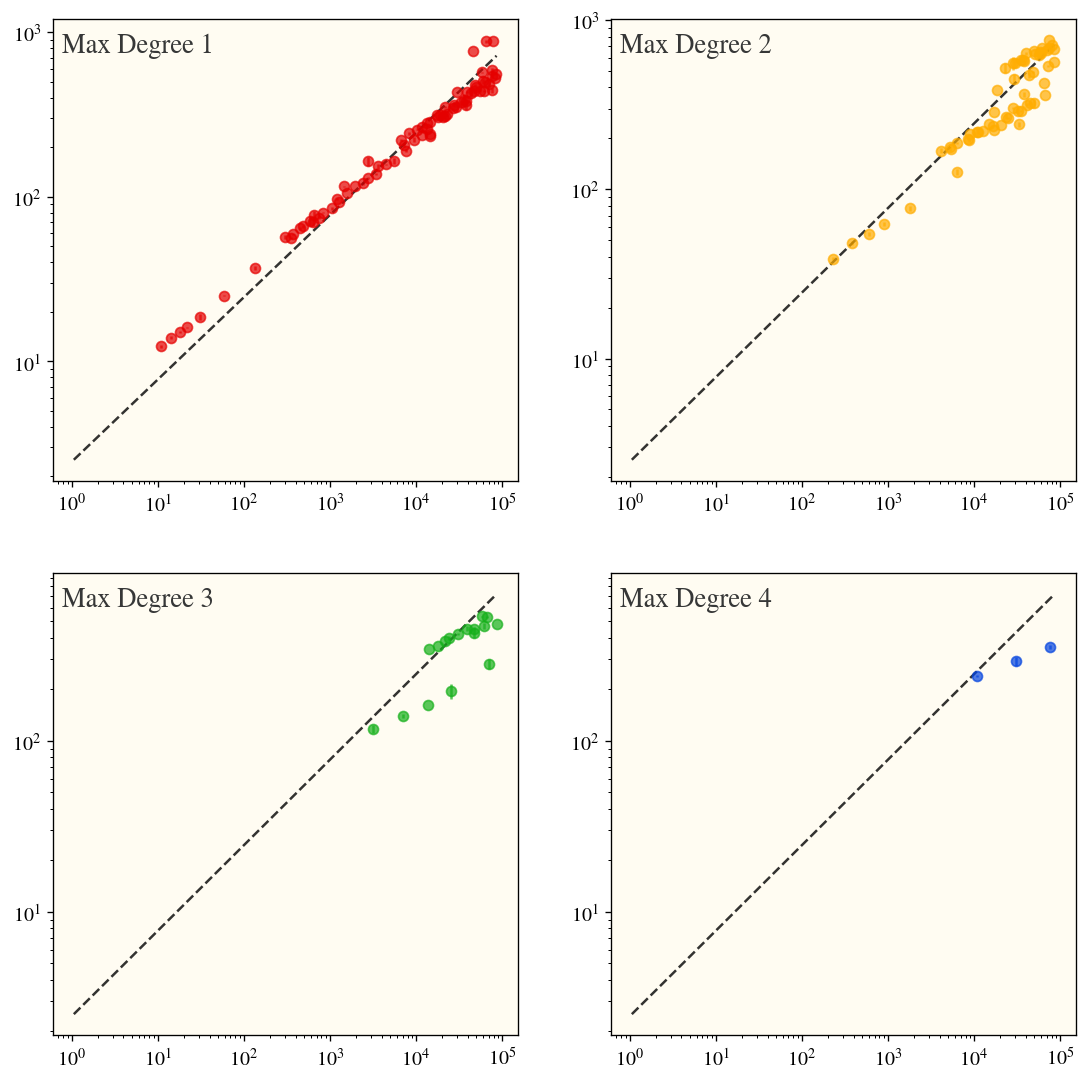

In [827]:
fig, axes = plt.subplots(2, 2, figsize=(11, 11), sharex=False, sharey=False)
s = 6
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)*lr_base
breakpoints_std = (nanvar(torch.as_tensor(timekeys_base[-1]), axis=-1))**(0.5)*lr_base

xaxis = ((hea_eigvals[locs_base.long()].cpu()))**(-1.)

for idx, ax in enumerate(axes.flatten()):
	tbase = [Monomial.from_repr(t) for t in targets_base]

	maxdeglocs = np.where(np.array([m.max_degree() for m in tbase]) == idx+1)[0]
	ax.errorbar(xaxis[maxdeglocs], breakpoints_means[maxdeglocs], yerr=breakpoints_std[maxdeglocs], color=colors[idx+1],
			 fmt='o', alpha=0.7, markersize=s)
	if idx == 0:
		_, interc = get_log_log_linear_fit(xaxis[maxdeglocs].float(), breakpoints_means[maxdeglocs].float(), fixed_slope=0.5)
	ax.plot(xaxis, 10**(interc)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")
	ax.text(0.02, 0.97, f"Max Degree {idx+1}", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")
	ax.set_xscale('log')
	ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()

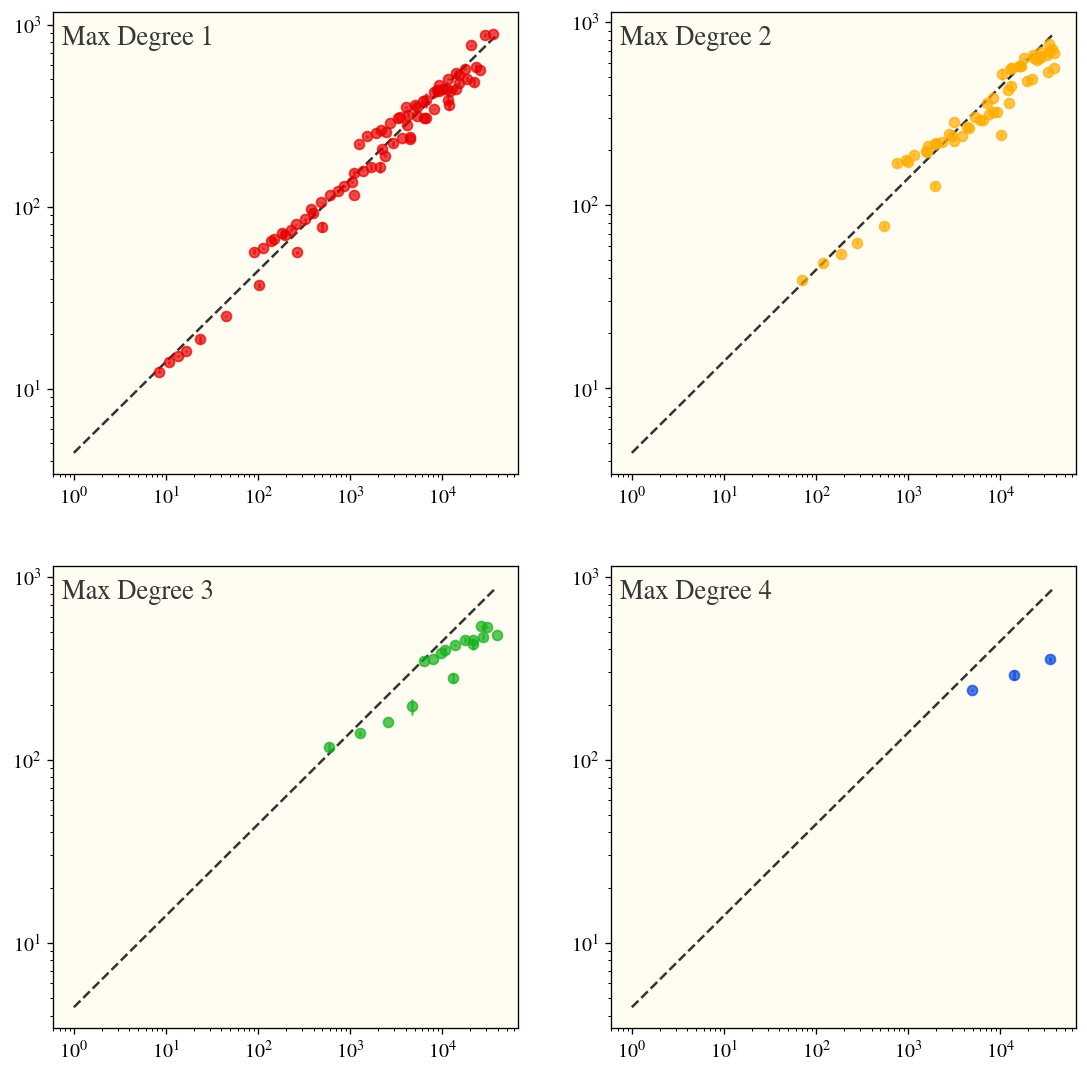

In [875]:
fig, axes = plt.subplots(2, 2, figsize=(11, 11), sharex=False, sharey=False)
s = 6
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)*lr_base
breakpoints_std = (nanvar(torch.as_tensor(timekeys_base[-1]), axis=-1))**(0.5)*lr_base

xaxis = ((raw_eigvals[locs_base.long()].cpu()))**(-1.)

for idx, ax in enumerate(axes.flatten()):
	tbase = [Monomial.from_repr(t) for t in targets_base]

	maxdeglocs = np.where(np.array([m.max_degree() for m in tbase]) == idx+1)[0]
	ax.errorbar(xaxis[maxdeglocs], breakpoints_means[maxdeglocs], yerr=breakpoints_std[maxdeglocs], color=colors[idx+1],
			 fmt='o', alpha=0.7, markersize=s)
	if idx == 0:
		_, interc = get_log_log_linear_fit(xaxis[maxdeglocs].float(), breakpoints_means[maxdeglocs].float(), fixed_slope=0.5)
	ax.plot(xaxis, 10**(interc)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")
	ax.text(0.02, 0.97, f"Max Degree {idx+1}", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")
	ax.set_xscale('log')
	ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()

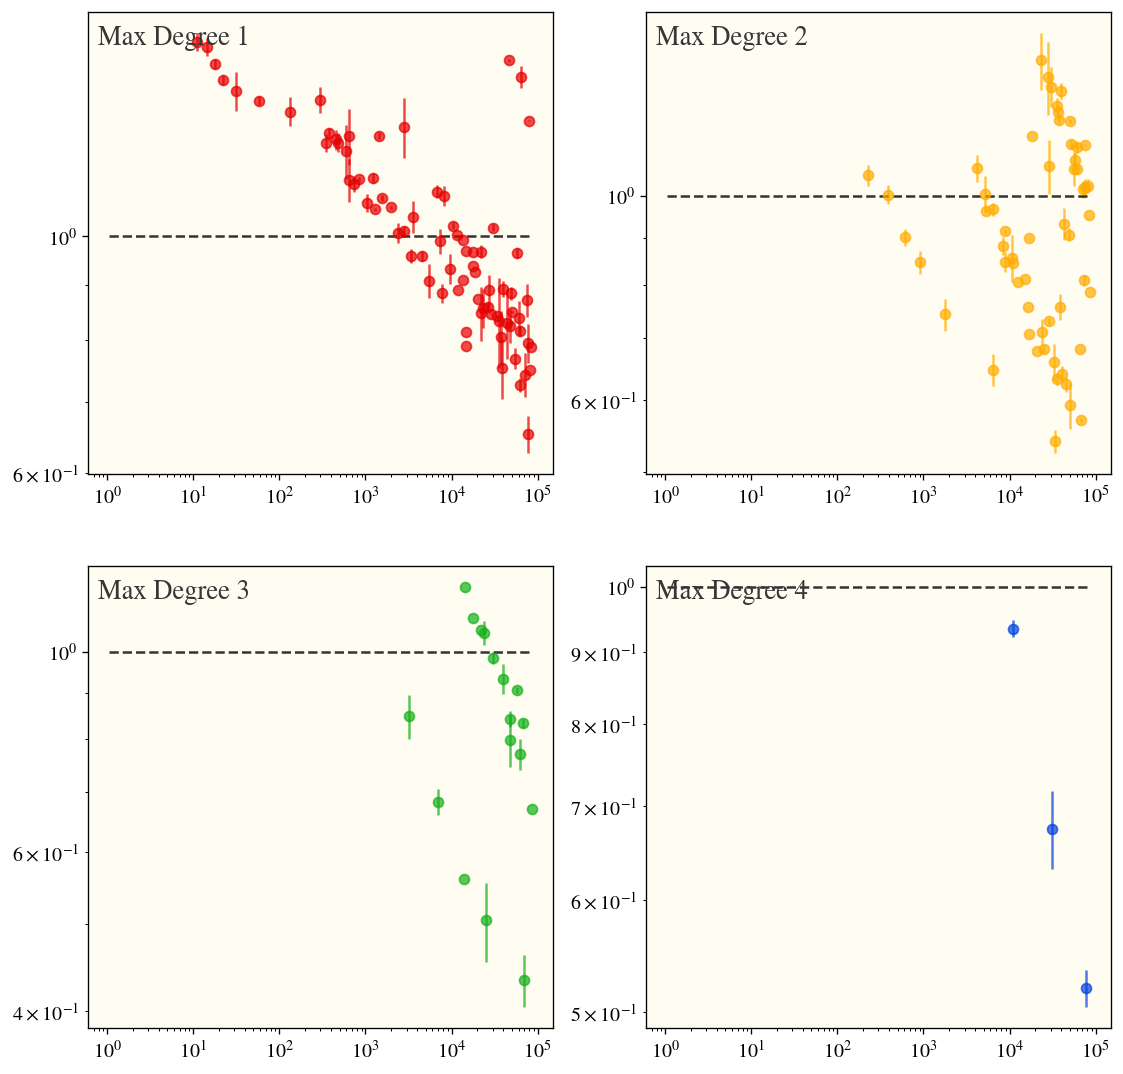

In [835]:
fig, axes = plt.subplots(2, 2, figsize=(11, 11), sharex=False, sharey=False)
s = 6
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)*lr_base
breakpoints_std = (nanvar(torch.as_tensor(timekeys_base[-1]), axis=-1))**(0.5)*lr_base

xaxis = ((hea_eigvals[locs_base.long()].cpu()))**(-1.)

for idx, ax in enumerate(axes.flatten()):
	tbase = [Monomial.from_repr(t) for t in targets_base]

	maxdeglocs = np.where(np.array([m.max_degree() for m in tbase]) == idx+1)[0]
	if idx == 0:
		_, interc = get_log_log_linear_fit(xaxis[maxdeglocs].float(), breakpoints_means[maxdeglocs].float(), fixed_slope=0.5)
	ax.errorbar(xaxis[maxdeglocs], breakpoints_means[maxdeglocs]/(10**(interc)*(xaxis[maxdeglocs])**(0.5)),
			 yerr=breakpoints_std[maxdeglocs]/(10**(interc)*(xaxis[maxdeglocs])**(0.5)), color=colors[idx+1],
			 fmt='o', alpha=0.7, markersize=s)
	ax.plot(xaxis, np.ones(len(xaxis)), color='k', linestyle='--', alpha=0.8)# label=f"")
	ax.text(0.02, 0.97, f"Max Degree {idx+1}", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")
	ax.set_xscale('log')
	ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()

(1, 1) 0.5 0.52
(2, 2) 0.3333333333333333 0.8220486044883728
(2, 1) 0.5 0.52
(3, 3) 0.25 1.1954180002212524
(3, 2) 0.3333333333333333 0.9831430912017822
(3, 1) 0.5 0.52
(4, 3) 0.25 1.4934622049331665
(4, 2) 0.3333333333333333 1.2093392610549927
(4, 1) 0.5 0.52


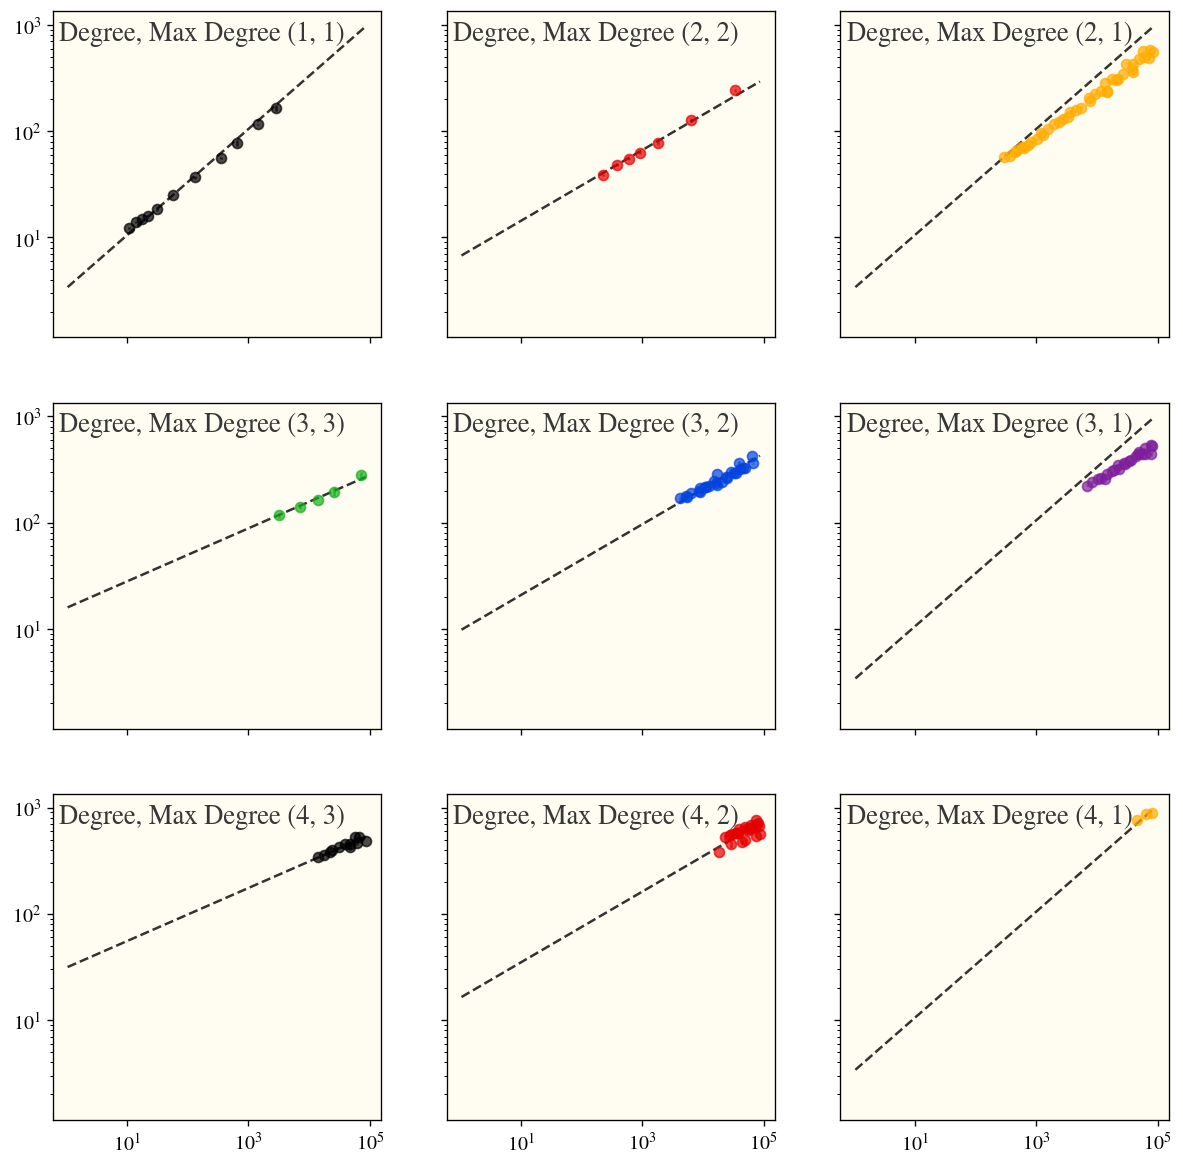

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
s = 6
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)*lr_base
breakpoints_std = (nanvar(torch.as_tensor(timekeys_base[-1]), axis=-1))**(0.5)*lr_base

xaxis = ((hea_eigvals[locs_base.long()].cpu()))**(-1.)
combos = [(1, 1), (2, 2), (2, 1), (3, 3), (3, 2), (3, 1), (4, 3), (4, 2), (4, 1)]

for idx, ax in enumerate(axes.flatten()):
	tbase = [Monomial.from_repr(t) for t in targets_base]
	combo = combos[idx]

	comboloc = np.where(np.array([(m.degree(), m.max_degree()) == combo for m in tbase]))[0]
	ax.errorbar(xaxis[comboloc], breakpoints_means[comboloc], yerr=breakpoints_std[comboloc], color=colors[idx%len(colors)],
			 fmt='o', alpha=0.7, markersize=s)
	# print(breakpoints_means[comboloc], targets_base[comboloc])
	# sl, interc = get_log_log_linear_fit(xaxis[comboloc].float(), breakpoints_means[comboloc].float())#, fixed_slope=0.5)
	# if combo[1] == 1:
	# 	sl, interc = get_log_log_linear_fit(xaxis[comboloc].float(), breakpoints_means[comboloc].float(), fixed_slope=0.5)
	sl, interc = get_log_log_linear_fit(xaxis[comboloc].float(), breakpoints_means[comboloc].float(), fixed_slope=(1/(combo[1]+1)))
	if combo[1] == 1:
		interc=0.52
	print(combo, sl, interc)
	ax.plot(xaxis, 10**(interc)*(xaxis)**(sl), color='k', linestyle='--', alpha=0.8)
	# ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")
	ax.text(0.02, 0.97, f"Degree, Max Degree {combo}", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")
	ax.set_xscale('log')
	ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()


(1, 1) 0.5 0.52
(2, 2) 0.3333333333333333 0.9933357238769531
(2, 1) 0.5 0.52
(3, 3) 0.25 1.3793455362319946
(3, 2) 0.3333333333333333 1.2283799648284912
(3, 1) 0.5 0.52
(4, 3) 0.25 1.5803450345993042
(4, 2) 0.3333333333333333 1.3251826763153076
(4, 1) 0.5 0.52


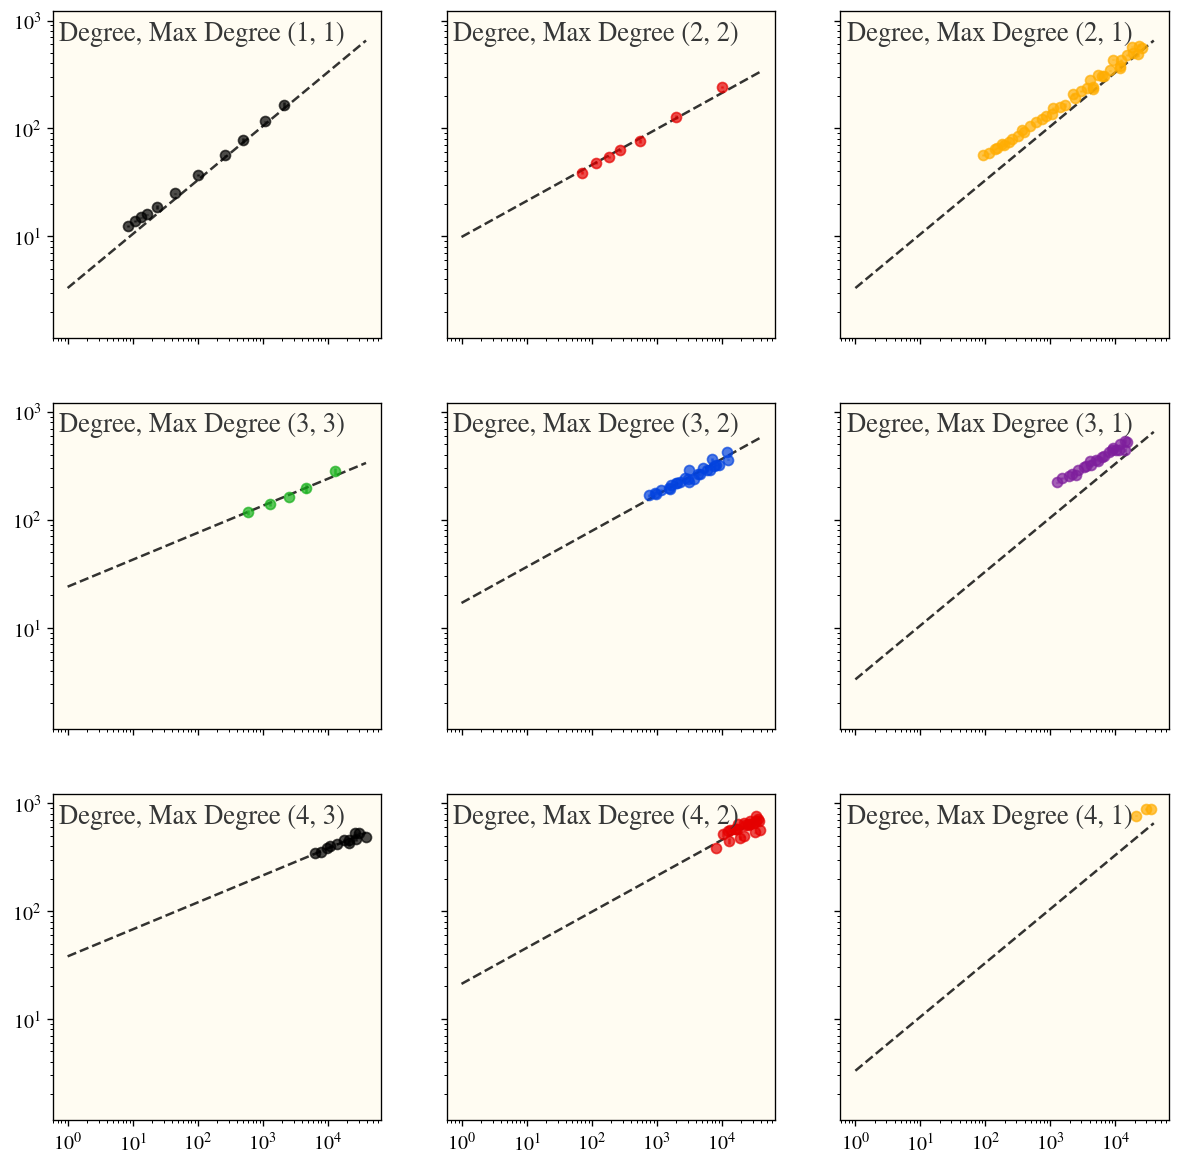

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
s = 6
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)*lr_base
breakpoints_std = (nanvar(torch.as_tensor(timekeys_base[-1]), axis=-1))**(0.5)*lr_base

xaxis = ((raw_eigvals[locs_base.long()].cpu()))**(-1.)
combos = [(1, 1), (2, 2), (2, 1), (3, 3), (3, 2), (3, 1), (4, 3), (4, 2), (4, 1)]

for idx, ax in enumerate(axes.flatten()):
	tbase = [Monomial.from_repr(t) for t in targets_base]
	combo = combos[idx]

	comboloc = np.where(np.array([(m.degree(), m.max_degree()) == combo for m in tbase]))[0]
	ax.errorbar(xaxis[comboloc], breakpoints_means[comboloc], yerr=breakpoints_std[comboloc], color=colors[idx%len(colors)],
			 fmt='o', alpha=0.7, markersize=s)
	# print(breakpoints_means[comboloc], targets_base[comboloc])
	# sl, interc = get_log_log_linear_fit(xaxis[comboloc].float(), breakpoints_means[comboloc].float())#, fixed_slope=0.5)
	# if combo[1] == 1:
	# 	sl, interc = get_log_log_linear_fit(xaxis[comboloc].float(), breakpoints_means[comboloc].float(), fixed_slope=0.5)
	sl, interc = get_log_log_linear_fit(xaxis[comboloc].float(), breakpoints_means[comboloc].float(), fixed_slope=(1/(combo[1]+1)))
	if combo[1] == 1:
		interc=0.52
	print(combo, sl, interc)
	ax.plot(xaxis, 10**(interc)*(xaxis)**(sl), color='k', linestyle='--', alpha=0.8)
	# ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")
	ax.text(0.02, 0.97, f"Degree, Max Degree {combo}", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")
	ax.set_xscale('log')
	ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()




(1, 1) 0.5 0.3885905146598816
[(tensor(11.0374), $x_{0}$, tensor(12.3667)), (tensor(14.3443), $x_{1}$, tensor(13.9467)), (tensor(17.9995), $x_{2}$, tensor(15.0700)), (tensor(21.9901), $x_{3}$, tensor(16.0767)), (tensor(30.9301), $x_{5}$, tensor(18.6300)), (tensor(58.4795), $x_{10}$, tensor(25.0900)), (tensor(133.4953), $x_{20}$, tensor(37.0167)), (tensor(297.4243), $x_{0}x_{1}$, tensor(56.6200)), (tensor(352.1251), $x_{40}$, tensor(56.2100)), (tensor(373.2179), $x_{0}x_{2}$, tensor(59.0500)), (tensor(455.9548), $x_{0}x_{3}$, tensor(64.4133)), (tensor(485.0366), $x_{1}x_{2}$, tensor(65.9867)), (tensor(592.5574), $x_{1}x_{3}$, tensor(71.5667)), (tensor(641.3134), $x_{0}x_{5}$, tensor(69.9267)), (tensor(650.4911), $x_{60}$, tensor(77.5300)), (tensor(743.5497), $x_{2}x_{3}$, tensor(74.7200)), (tensor(833.4722), $x_{1}x_{5}$, tensor(79.8900)), (tensor(1045.8719), $x_{2}x_{5}$, tensor(85.0733)), (tensor(1212.6062), $x_{0}x_{10}$, tensor(96.6133)), (tensor(1277.7267), $x_{3}x_{5}$, tensor(92.

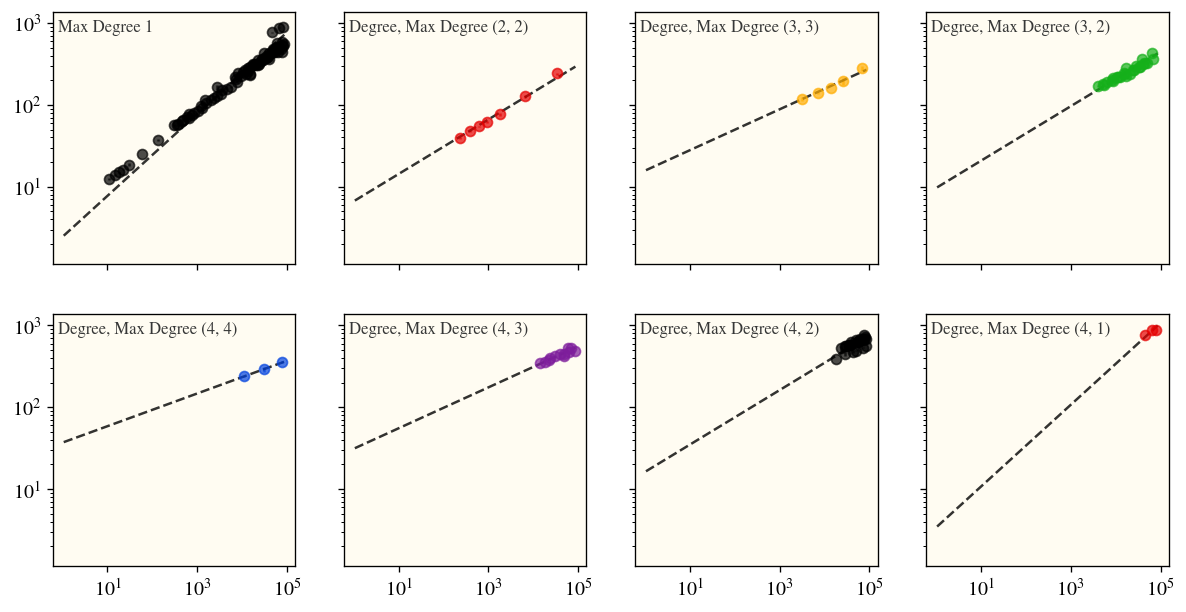

In [883]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
s = 6
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)*lr_base
breakpoints_std = (nanvar(torch.as_tensor(timekeys_base[-1]), axis=-1))**(0.5)*lr_base

xaxis = ((hea_eigvals[locs_base.long()].cpu()))**(-1.)
combos = [(1, 1), (2, 2), (3, 3), (3, 2), (4, 4), (4, 3), (4, 2), (4, 1)]

for idx, ax in enumerate(axes.flatten()):
	tbase = [Monomial.from_repr(t) for t in targets_base]
	combo = combos[idx]
	if idx == 0:
		comboloc = np.where(np.array([m.max_degree() == 1 for m in tbase]))[0]
	else:
		comboloc = np.where(np.array([(m.degree(), m.max_degree()) == combo for m in tbase]))[0]
	ax.errorbar(xaxis[comboloc], breakpoints_means[comboloc], yerr=breakpoints_std[comboloc], color=colors[idx%len(colors)],
			 fmt='o', alpha=0.7, markersize=s)
	# print(breakpoints_means[comboloc], targets_base[comboloc])
	# sl, interc = get_log_log_linear_fit(xaxis[comboloc].float(), breakpoints_means[comboloc].float())#, fixed_slope=0.5)
	# if combo[1] == 1:
	# 	sl, interc = get_log_log_linear_fit(xaxis[comboloc].float(), breakpoints_means[comboloc].float(), fixed_slope=0.5)
	sl, interc = get_log_log_linear_fit(xaxis[comboloc].float(), breakpoints_means[comboloc].float(), fixed_slope=(1/(combo[1]+1)))
	# if combo[1] == 1:
	# 	interc=0.52
	print(combo, sl, interc)
	ax.plot(xaxis, 10**(interc)*(xaxis)**(sl), color='k', linestyle='--', alpha=0.8)
	# ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")
	if idx == 0:
		ax.text(0.02, 0.97, f"Max Degree 1", ha="left", va="top",
        	transform=ax.transAxes, fontsize=10, color="xkcd:dark gray")
		print(list(zip(xaxis[comboloc], np.array(tbase)[comboloc], breakpoints_means[comboloc].float())))
	else:
		ax.text(0.02, 0.97, f"Degree, Max Degree {combo}", ha="left", va="top",
        	transform=ax.transAxes, fontsize=10, color="xkcd:dark gray")
	ax.set_xscale('log')
	ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()


0.5 0.3885905146598816
0.3333333333333333 1.0585999488830566
0.25 1.4058022499084473
0.2 1.5690431594848633


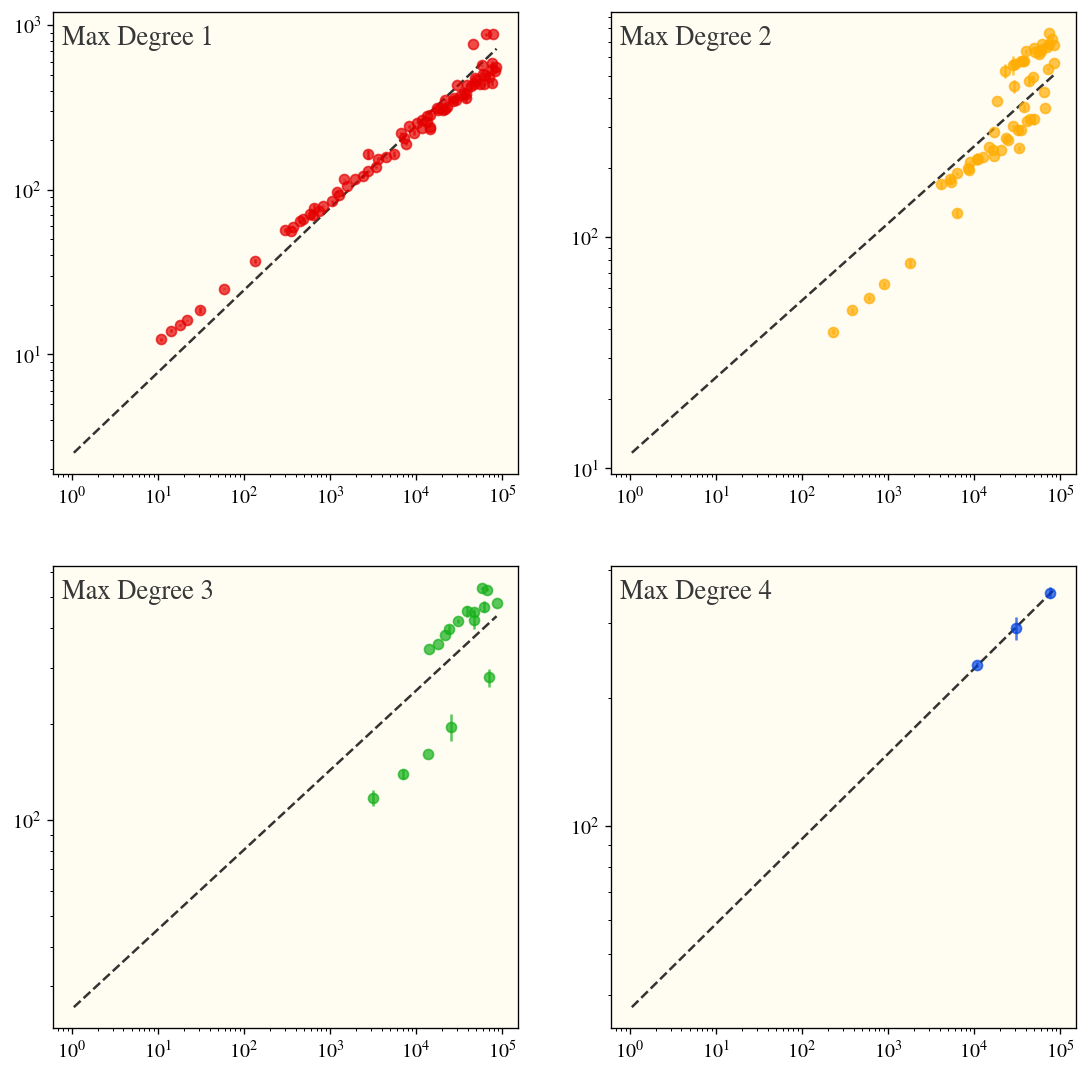

In [868]:
fig, axes = plt.subplots(2, 2, figsize=(11, 11), sharex=False, sharey=False)
s = 6
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)*lr_base
breakpoints_std = (nanvar(torch.as_tensor(timekeys_base[-1]), axis=-1))**(0.5)*lr_base

xaxis = ((hea_eigvals[locs_base.long()].cpu()))**(-1.)

for idx, ax in enumerate(axes.flatten()):
	tbase = [Monomial.from_repr(t) for t in targets_base]

	maxdeglocs = np.where(np.array([m.max_degree() for m in tbase]) == idx+1)[0]
	ax.errorbar(xaxis[maxdeglocs], breakpoints_means[maxdeglocs], yerr=breakpoints_std[maxdeglocs], color=colors[idx+1],
			 fmt='o', alpha=0.7, markersize=s)
	# if idx == 0:
		# _, interc = get_log_log_linear_fit(xaxis[maxdeglocs].float(), breakpoints_means[maxdeglocs].float(), fixed_slope=0.5)
	sl, interc = get_log_log_linear_fit(xaxis[maxdeglocs].float(), breakpoints_means[maxdeglocs].float(), fixed_slope=(1/((idx+1)+1)))
	print(sl, interc)
	ax.plot(xaxis, 10**(interc)*(xaxis)**(sl), color='k', linestyle='--', alpha=0.8)# label=f"")
	ax.text(0.02, 0.97, f"Max Degree {idx+1}", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")
	ax.set_xscale('log')
	ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()

['$x_{0}^2x_{2}^2$' '$x_{0}^2x_{3}^2$' '$x_{1}^2x_{2}^2$'
 '$x_{1}^2x_{3}^2$' '$x_{0}^2x_{1}^2$' '$x_{0}^2x_{5}^2$']
0.2324519157409668 1.602433443069458
['$x_{0}^2x_{1}x_{2}$' '$x_{0}^2x_{1}x_{3}$' '$x_{0}x_{1}^2x_{2}$'
 '$x_{0}^2x_{2}x_{3}$' '$x_{0}x_{1}^2x_{3}$' '$x_{0}x_{1}x_{2}^2$'
 '$x_{0}^2x_{1}x_{5}$' '$x_{0}^2x_{2}x_{5}$' '$x_{0}x_{1}^2x_{5}$'
 '$x_{0}x_{1}x_{3}^2$' '$x_{0}x_{2}^2x_{3}$' '$x_{1}^2x_{2}x_{3}$'
 '$x_{0}^2x_{3}x_{5}$' '$x_{0}x_{2}x_{3}^2$' '$x_{1}x_{2}^2x_{3}$'
 '$x_{0}^2x_{1}x_{10}$' '$x_{0}x_{2}^2x_{5}$' '$x_{1}^2x_{2}x_{5}$']
0.23369932174682617 1.702301263809204


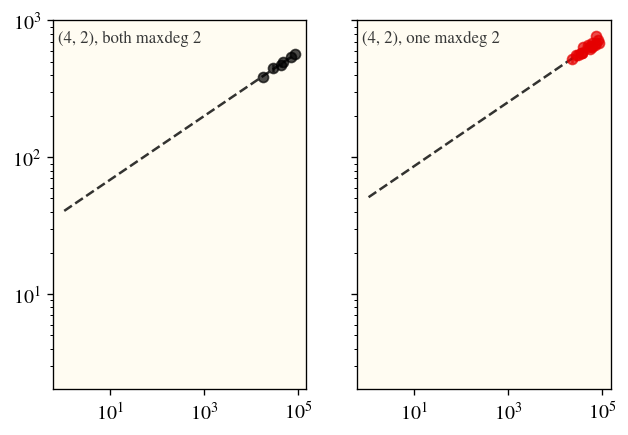

In [858]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharex=True, sharey=True)
s = 6
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)*lr_base
breakpoints_std = (nanvar(torch.as_tensor(timekeys_base[-1]), axis=-1))**(0.5)*lr_base

xaxis = ((hea_eigvals[locs_base.long()].cpu()))**(-1.)
cb = (4, 2)

for idx, ax in enumerate(axes.flatten()):
	tbase = [Monomial.from_repr(t) for t in targets_base]
	
	cbloc = np.where(np.array([(m.degree(), m.max_degree()) == cb for m in tbase]))[0]
	basis_list_base = [t.basis() for t in tbase if (t.degree(), t.max_degree()) == cb]
	if idx == 0:
		blbidxs = [i for i, d in enumerate(basis_list_base) if d and all(v == 2 for v in d.values())]
		print(targets_base[cbloc][blbidxs])
		ax.text(0.02, 0.97, f"{cb}, both maxdeg 2", ha="left", va="top",
        	transform=ax.transAxes, fontsize=10, color="xkcd:dark gray")
	else:
		blbidxs = [i for i, d in enumerate(basis_list_base) if d and not all(v == 2 for v in d.values())]
		print(targets_base[cbloc][blbidxs])
		ax.text(0.02, 0.97, f"{cb}, one maxdeg 2", ha="left", va="top",
        	transform=ax.transAxes, fontsize=10, color="xkcd:dark gray")
	ax.errorbar(xaxis[cbloc][blbidxs], breakpoints_means[cbloc][blbidxs], yerr=breakpoints_std[cbloc][blbidxs], color=colors[idx%len(colors)],
			 fmt='o', alpha=0.7, markersize=s)
	sl, interc = get_log_log_linear_fit(xaxis[cbloc][blbidxs].float(), breakpoints_means[cbloc][blbidxs].float())#, fixed_slope=(1/(cb[1]+1)))
	# print(breakpoints_means[cbloc], targets_base[cbloc])
	print(sl, interc)
	ax.plot(xaxis, 10**(interc)*(xaxis)**(sl), color='k', linestyle='--', alpha=0.8)
	ax.set_xscale('log')
	ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()


## depth
slope changed ~0.46->0.7

In [ ]:
timekeys_depth, targets_depth, num_trials_depth, _ = parse_timekeys_to_array(result_depth)
locs_depth = torch.zeros(len(targets_depth))

for i, monomial in enumerate(targets_depth):
    monomial = Monomial.from_repr(monomial)
    # print(np.where(np.array(monomials) == monomial))
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_depth[-1]), axis=-1)):
        break
    # print(loc)
    loc = np.where(np.array(monomials) == monomial)[0][0]
    locs_depth[i] = loc

In [ ]:
tags_depth = [{}, {1:1}, {5:1},
        {0:2}, {0:1,2:1}]
noteable_targets_depth = list(map(Monomial, tags_depth))
t2 = list(map(Monomial.from_repr, targets_depth))
noteable_locs_depth = torch.ones(len(noteable_targets_depth))
noteable_y_depth = torch.ones(len(noteable_targets_depth))

for i, monomial in enumerate(noteable_targets_depth):
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_depth[-1]), axis=-1)):
        break
    if monomial in monomials:
        loc = np.where(np.array(monomials) == monomial)[0][0]
        noteable_locs_depth[i] = loc
    if monomial in t2:
        loc = np.where(np.array(t2) == monomial)[0][0]
        noteable_y_depth[i] = loc
# noteable_targets_depth
# noteable_y_depth


In [ ]:
s = 6
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_depth[-1]), axis=-1)*lr_depth
breakpoints_std = (nanvar(torch.as_tensor(timekeys_depth[-1]), axis=-1))**(0.5)*lr_depth

xaxis = ((hea_eigvals[locs_depth.long()].cpu()))**(-1.)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_depth.long()].cpu(), breakpoints_means.cpu(), targets_depth,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(0.7)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")

#points
point_locs_depth = [3, 3, 3, 3, 3]

for idx, xi, yi in zip(noteable_locs_depth, hea_eigvals[noteable_locs_depth.long()]**(-1.), breakpoints_means[noteable_y_depth.long()]):
    m = Monomial(monomials[idx.int().cpu().numpy()])
    if m in tags_depth:
        color = colors[m.degree() % len(colors)]
        ax.scatter(xi, yi, color = color, alpha=1, zorder=10, s=s**2.)
        i = tags_depth.index(monomials[idx.int().cpu().numpy()])
        kwargs = {"ha": "left" if point_locs_depth[i] < 2 else "right",
                  "va": "bottom" if point_locs_depth[i] % 2 == 1 else "top"}
        z = 0.08
        off = (
            z if point_locs_depth[i] < 2 else -z,
            z if point_locs_depth[i] % 2 == 1 else -z
        )
        ax.annotate(str(m).replace('x', 'z'), (xi*(1+off[0]), yi*(1+off[1])), fontsize=13,
                    color=lighten(color, -0.2), alpha=0.7, **kwargs)
        

#triangle 
x0, y0 = 2, 5
dlogx = 1        
dlogy = 0.5 * dlogx 
x1 = x0 * 10**dlogx
y1 = y0 * 10**dlogy
dx = x1 - x0
dy = y1 - y0
x_coords = [x0, x1, x1]
y_coords = [y0, y0, y1]
ax.plot(x_coords, y_coords, 'k-', linewidth=0.5)
ax.plot([x0, x1], [y0, y1], 'k-', linewidth=0.5)  
ax.text(x0+dx*1.1, y0+dy*(np.log10(2)), r'$1/2$', 
         va='center', ha='left', fontsize=13, fontweight="light")

ax.text(0.02, 0.97, f"MLP @ Gaussian Data", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

color_handles = make_color_handles(colors, max_handle=2, s=s)
all_handles = color_handles
ax.legend(
        handles=all_handles,
        ncol=1,#2,
        loc="lower right",
        frameon=False,
        columnspacing=1.2,
        handletextpad=0.6,   
    )

ax.set_xlabel(r'Inverse of HEA eigenvalue $\lambda_{\boldsymbol{\alpha}}^{-1}$', fontsize=14)
ax.set_ylabel("Eff. opt. time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()

## lr
under def of TTK, intercept unaffected

In [ ]:
timekeys_lr, targets_lr, num_trials_lr, _ = parse_timekeys_to_array(result_lr)
locs_lr = torch.zeros(len(targets_lr))

for i, monomial in enumerate(targets_lr):
    monomial = Monomial.from_repr(monomial)
    # print(np.where(np.array(monomials) == monomial))
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_lr[-1]), axis=-1)):
        break
    # print(loc)
    loc = np.where(np.array(monomials) == monomial)[0][0]
    locs_lr[i] = loc

In [ ]:
tags_lr = [{}, {1:1}, {5:1}, {100:1}, {204:1},
        {0:2}, {0:1,2:1}, {2:1, 3:1}, {1:1,10:1}, #{1:1,40:1},
        {1:3}, {0:1, 1:1, 2:1}]#,
        # {0:4}, {0:1, 1:1, 2:1, 3:1}]
noteable_targets_lr = list(map(Monomial, tags_lr))
t2 = list(map(Monomial.from_repr, targets_lr))
noteable_locs_lr = torch.zeros(len(noteable_targets_lr))
noteable_y_lr = torch.zeros(len(noteable_targets_lr))

for i, monomial in enumerate(noteable_targets_lr):
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_lr[-1]), axis=-1)):
        break
    if monomial in monomials:
        loc = np.where(np.array(monomials) == monomial)[0][0]
        noteable_locs_lr[i] = loc
    if monomial in t2:
        loc = np.where(np.array(t2) == monomial)[0][0]
        noteable_y_lr[i] = loc
# noteable_targets_lr

In [ ]:
s = 6
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_lr[-1]), axis=-1)*lr_lr
breakpoints_std = (nanvar(torch.as_tensor(timekeys_lr[-1]), axis=-1))**(0.5)*lr_lr

xaxis = ((hea_eigvals[locs_lr.long()].cpu()))**(-1.)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_lr.long()].cpu(), breakpoints_means.cpu(), targets_lr,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")

#points
point_locs_lr = [3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0]

for idx, xi, yi in zip(noteable_locs_lr, hea_eigvals[noteable_locs_lr.long()]**(-1.), breakpoints_means[noteable_y_lr.long()]):
    m = Monomial(monomials[idx.int().cpu().numpy()])
    if m in tags_lr:
        color = colors[m.degree() % len(colors)]
        ax.scatter(xi, yi, color = color, alpha=1, zorder=10, s=s**2.)
        i = tags_lr.index(monomials[idx.int().cpu().numpy()])
        kwargs = {"ha": "left" if point_locs_lr[i] < 2 else "right",
                  "va": "bottom" if point_locs_lr[i] % 2 == 1 else "top"}
        z = 0.08
        off = (
            z if point_locs_lr[i] < 2 else -z,
            z if point_locs_lr[i] % 2 == 1 else -z
        )
        ax.annotate(str(m).replace('x', 'z'), (xi*(1+off[0]), yi*(1+off[1])), fontsize=13,
                    color=lighten(color, -0.2), alpha=0.7, **kwargs)
        

#triangle 
x0, y0 = 3, 4
dlogx = 1        
dlogy = 0.5 * dlogx 
x1 = x0 * 10**dlogx
y1 = y0 * 10**dlogy
dx = x1 - x0
dy = y1 - y0
x_coords = [x0, x1, x1]
y_coords = [y0, y0, y1]
ax.plot(x_coords, y_coords, 'k-', linewidth=0.5)
ax.plot([x0, x1], [y0, y1], 'k-', linewidth=0.5)  
ax.text(x0+dx*1.1, y0+dy*(np.log10(2)), r'$1/2$', 
         va='center', ha='left', fontsize=13, fontweight="light")

ax.text(0.02, 0.97, f"MLP @ Gaussian Data", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

color_handles = make_color_handles(colors, max_handle=4, s=s)
all_handles = color_handles
ax.legend(
        handles=all_handles,
        ncol=1,#2,
        loc="lower right",
        frameon=False,
        columnspacing=1.2,
        handletextpad=0.6,   
    )

ax.set_xlabel(r'Inverse of HEA eigenvalue $\lambda_{\boldsymbol{\alpha}}^{-1}$', fontsize=14)
ax.set_ylabel("Eff. opt. time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()

## width
unaffected

In [ ]:
timekeys_width, targets_width, num_trials_width, _ = parse_timekeys_to_array(result_width)
locs_width = torch.zeros(len(targets_width))

for i, monomial in enumerate(targets_width):
    monomial = Monomial.from_repr(monomial)
    # print(np.where(np.array(monomials) == monomial))
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_width[-1]), axis=-1)):
        break
    # print(loc)
    loc = np.where(np.array(monomials) == monomial)[0][0]
    locs_width[i] = loc

In [ ]:
tags_width = [{}, {1:1}, {5:1}, {0:2}, {0:1, 1:1},
                    {0:1, 5:1}, {0:3}, {0:2, 2:1}, {0:1, 2:1, 3:1},
                    {0:4}]
noteable_targets_width = list(map(Monomial, tags_width))
t2 = list(map(Monomial.from_repr, targets_width))
noteable_locs_width = torch.zeros(len(noteable_targets_width))
noteable_y_width = torch.zeros(len(noteable_targets_width))

for i, monomial in enumerate(noteable_targets_width):
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_width[-1]), axis=-1)):
        break
    if monomial in monomials:
        loc = np.where(np.array(monomials) == monomial)[0][0]
        noteable_locs_width[i] = loc
    if monomial in t2:
        loc = np.where(np.array(t2) == monomial)[0][0]
        noteable_y_width[i] = loc
# noteable_targets_width

In [ ]:
s = 6
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_width[-1]), axis=-1)*lr_width
breakpoints_std = (nanvar(torch.as_tensor(timekeys_width[-1]), axis=-1))**(0.5)*lr_width

xaxis = ((hea_eigvals[locs_width.long()].cpu()))**(-1.)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_width.long()].cpu(), breakpoints_means.cpu(), targets_width,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")

#points
point_locs_width = [3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for idx, xi, yi in zip(noteable_locs_width, hea_eigvals[noteable_locs_width.long()]**(-1.), breakpoints_means[noteable_y_width.long()]):
    m = Monomial(monomials[idx.int().cpu().numpy()])
    if m in tags_width:
        color = colors[m.degree() % len(colors)]
        ax.scatter(xi, yi, color = color, alpha=1, zorder=10, s=s**2.)
        i = tags_width.index(monomials[idx.int().cpu().numpy()])
        kwargs = {"ha": "left" if point_locs_width[i] < 2 else "right",
                  "va": "bottom" if point_locs_width[i] % 2 == 1 else "top"}
        z = 0.08
        off = (
            z if point_locs_width[i] < 2 else -z,
            z if point_locs_width[i] % 2 == 1 else -z
        )
        ax.annotate(str(m).replace('x', 'z'), (xi*(1+off[0]), yi*(1+off[1])), fontsize=13,
                    color=lighten(color, -0.2), alpha=0.7, **kwargs)
        

#triangle 
x0, y0 = 3, 4
dlogx = 1        
dlogy = 0.5 * dlogx 
x1 = x0 * 10**dlogx
y1 = y0 * 10**dlogy
dx = x1 - x0
dy = y1 - y0
x_coords = [x0, x1, x1]
y_coords = [y0, y0, y1]
ax.plot(x_coords, y_coords, 'k-', linewidth=0.5)
ax.plot([x0, x1], [y0, y1], 'k-', linewidth=0.5)  
ax.text(x0+dx*1.1, y0+dy*(np.log10(2)), r'$1/2$', 
         va='center', ha='left', fontsize=13, fontweight="light")

ax.text(0.02, 0.97, f"MLP @ Gaussian Data", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

color_handles = make_color_handles(colors, max_handle=4, s=s)
all_handles = color_handles
ax.legend(
        handles=all_handles,
        ncol=1,#2,
        loc="lower right",
        frameon=False,
        columnspacing=1.2,
        handletextpad=0.6,   
    )

ax.set_xlabel(r'Inverse of HEA eigenvalue $\lambda_{\boldsymbol{\alpha}}^{-1}$', fontsize=14)
ax.set_ylabel("Eff. opt. time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()

## bsz
unaffected

In [ ]:
timekeys_bsz, targets_bsz, num_trials_bsz, _ = parse_timekeys_to_array(result_bsz)
locs_bsz = torch.zeros(len(targets_bsz))

for i, monomial in enumerate(targets_bsz):
    monomial = Monomial.from_repr(monomial)
    # print(np.where(np.array(monomials) == monomial))
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_bsz[-1]), axis=-1)):
        break
    # print(loc)
    loc = np.where(np.array(monomials) == monomial)[0][0]
    locs_bsz[i] = loc

In [ ]:
tags_bsz = [{}, {1:1}, {5:1}, {0:2}, {0:1, 1:1},
                    {0:1, 5:1}]
noteable_targets_bsz = list(map(Monomial, tags_bsz))
t2 = list(map(Monomial.from_repr, targets_bsz))
noteable_locs_bsz = torch.zeros(len(noteable_targets_bsz))
noteable_y_bsz = torch.zeros(len(noteable_targets_bsz))

for i, monomial in enumerate(noteable_targets_bsz):
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_bsz[-1]), axis=-1)):
        break
    if monomial in monomials:
        loc = np.where(np.array(monomials) == monomial)[0][0]
        noteable_locs_bsz[i] = loc
    if monomial in t2:
        loc = np.where(np.array(t2) == monomial)[0][0]
        noteable_y_bsz[i] = loc
# noteable_targets_bsz

In [ ]:
s = 6
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_bsz[-1]), axis=-1)*lr_bsz
breakpoints_std = (nanvar(torch.as_tensor(timekeys_bsz[-1]), axis=-1))**(0.5)*lr_bsz

xaxis = ((hea_eigvals[locs_bsz.long()].cpu()))**(-1.)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_bsz.long()].cpu(), breakpoints_means.cpu(), targets_bsz,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")

#points
point_locs_bsz = [3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for idx, xi, yi in zip(noteable_locs_bsz, hea_eigvals[noteable_locs_bsz.long()]**(-1.), breakpoints_means[noteable_y_bsz.long()]):
    m = Monomial(monomials[idx.int().cpu().numpy()])
    if m in tags_bsz:
        color = colors[m.degree() % len(colors)]
        ax.scatter(xi, yi, color = color, alpha=1, zorder=10, s=s**2.)
        i = tags_bsz.index(monomials[idx.int().cpu().numpy()])
        kwargs = {"ha": "left" if point_locs_bsz[i] < 2 else "right",
                  "va": "bottom" if point_locs_bsz[i] % 2 == 1 else "top"}
        z = 0.08
        off = (
            z if point_locs_bsz[i] < 2 else -z,
            z if point_locs_bsz[i] % 2 == 1 else -z
        )
        ax.annotate(str(m).replace('x', 'z'), (xi*(1+off[0]), yi*(1+off[1])), fontsize=13,
                    color=lighten(color, -0.2), alpha=0.7, **kwargs)
        

#triangle 
x0, y0 = 3, 4
dlogx = 1        
dlogy = 0.5 * dlogx 
x1 = x0 * 10**dlogx
y1 = y0 * 10**dlogy
dx = x1 - x0
dy = y1 - y0
x_coords = [x0, x1, x1]
y_coords = [y0, y0, y1]
ax.plot(x_coords, y_coords, 'k-', linewidth=0.5)
ax.plot([x0, x1], [y0, y1], 'k-', linewidth=0.5)  
ax.text(x0+dx*1.1, y0+dy*(np.log10(2)), r'$1/2$', 
         va='center', ha='left', fontsize=13, fontweight="light")

ax.text(0.02, 0.97, f"MLP @ Gaussian Data", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

color_handles = make_color_handles(colors, max_handle=4, s=s)
all_handles = color_handles
ax.legend(
        handles=all_handles,
        ncol=1,#2,
        loc="lower right",
        frameon=False,
        columnspacing=1.2,
        handletextpad=0.6,   
    )

ax.set_xlabel(r'Inverse of HEA eigenvalue $\lambda_{\boldsymbol{\alpha}}^{-1}$', fontsize=14)
ax.set_ylabel("Eff. opt. time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()

## data exponent

In [ ]:
timekeys_alpha, targets_alpha, num_trials_alpha, _ = parse_timekeys_to_array(result_alpha)
locs_alpha = torch.zeros(len(targets_alpha))

for i, monomial in enumerate(targets_alpha):
    monomial = Monomial.from_repr(monomial)
    # print(np.where(np.array(monomials) == monomial))
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_alpha[-1]), axis=-1)):
        break
    # print(loc)
    loc = np.where(np.array(monomials) == monomial)[0][0]
    locs_alpha[i] = loc

In [ ]:
tags_alpha = [{}, {1:1}, {5:1}, {100:1}, {204:1},
        {0:2}, {0:1,2:1}, {2:1, 3:1}, {1:1,10:1}, #{1:1,40:1},
        ]
noteable_targets_alpha = list(map(Monomial, tags_alpha))
t2 = list(map(Monomial.from_repr, targets_alpha))
noteable_locs_alpha = torch.zeros(len(noteable_targets_alpha))
noteable_y_alpha = torch.zeros(len(noteable_targets_alpha))

for i, monomial in enumerate(noteable_targets_alpha):
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_alpha[-1]), axis=-1)):
        break
    if monomial in monomials:
        loc = np.where(np.array(monomials) == monomial)[0][0]
        noteable_locs_alpha[i] = loc
    if monomial in t2:
        loc = np.where(np.array(t2) == monomial)[0][0]
        noteable_y_alpha[i] = loc
# noteable_targets_alpha

In [ ]:
s = 6
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_alpha[-1]), axis=-1)*lr_alpha
breakpoints_std = (nanvar(torch.as_tensor(timekeys_alpha[-1]), axis=-1))**(0.5)*lr_alpha

xaxis = ((hea_eigvals[locs_alpha.long()].cpu()))**(-1.)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_alpha.long()].cpu(), breakpoints_means.cpu(), targets_alpha,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")

#points
point_locs_alpha = [3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for idx, xi, yi in zip(noteable_locs_alpha, hea_eigvals[noteable_locs_alpha.long()]**(-1.), breakpoints_means[noteable_y_alpha.long()]):
    m = Monomial(monomials[idx.int().cpu().numpy()])
    if m in tags_alpha:
        color = colors[m.degree() % len(colors)]
        ax.scatter(xi, yi, color = color, alpha=1, zorder=10, s=s**2.)
        i = tags_alpha.index(monomials[idx.int().cpu().numpy()])
        kwargs = {"ha": "left" if point_locs_alpha[i] < 2 else "right",
                  "va": "bottom" if point_locs_alpha[i] % 2 == 1 else "top"}
        z = 0.08
        off = (
            z if point_locs_alpha[i] < 2 else -z,
            z if point_locs_alpha[i] % 2 == 1 else -z
        )
        ax.annotate(str(m).replace('x', 'z'), (xi*(1+off[0]), yi*(1+off[1])), fontsize=13,
                    color=lighten(color, -0.2), alpha=0.7, **kwargs)
        

#triangle 
x0, y0 = 3, 4
dlogx = 1        
dlogy = 0.5 * dlogx 
x1 = x0 * 10**dlogx
y1 = y0 * 10**dlogy
dx = x1 - x0
dy = y1 - y0
x_coords = [x0, x1, x1]
y_coords = [y0, y0, y1]
ax.plot(x_coords, y_coords, 'k-', linewidth=0.5)
ax.plot([x0, x1], [y0, y1], 'k-', linewidth=0.5)  
ax.text(x0+dx*1.1, y0+dy*(np.log10(2)), r'$1/2$', 
         va='center', ha='left', fontsize=13, fontweight="light")

ax.text(0.02, 0.97, f"MLP @ Gaussian Data", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

color_handles = make_color_handles(colors, max_handle=4, s=s)
all_handles = color_handles
ax.legend(
        handles=all_handles,
        ncol=1,#2,
        loc="lower right",
        frameon=False,
        columnspacing=1.2,
        handletextpad=0.6,   
    )

ax.set_xlabel(r'Inverse of HEA eigenvalue $\lambda_{\boldsymbol{\alpha}}^{-1}$', fontsize=14)
ax.set_ylabel("Eff. opt. time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()

## NTK
slope->1; intercept??

In [ ]:
timekeys_ntk, targets_ntk, num_trials_ntk, _ = parse_timekeys_to_array(result_ntk)
locs_ntk = torch.zeros(len(targets_ntk))

for i, monomial in enumerate(targets_ntk):
    monomial = Monomial.from_repr(monomial)
    # print(np.where(np.array(monomials) == monomial))
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_ntk[-1]), axis=-1)):
        break
    # print(loc)
    loc = np.where(np.array(monomials) == monomial)[0][0]
    locs_ntk[i] = loc

In [768]:
tags_ntk = [{}, {1:1}, {5:1},
        {0:2}, {0:1,2:1}, {0:3}]
noteable_targets_ntk = list(map(Monomial, tags_ntk))
t2 = list(map(Monomial.from_repr, targets_ntk))
noteable_locs_ntk = torch.zeros(len(noteable_targets_ntk))
noteable_y_ntk = torch.zeros(len(noteable_targets_ntk))

for i, monomial in enumerate(noteable_targets_ntk):
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_ntk[-1]), axis=-1)):
        break
    if monomial in monomials:
        loc = np.where(np.array(monomials) == monomial)[0][0]
        noteable_locs_ntk[i] = loc
    if monomial in t2:
        loc = np.where(np.array(t2) == monomial)[0][0]
        noteable_y_ntk[i] = loc
# noteable_targets_ntk

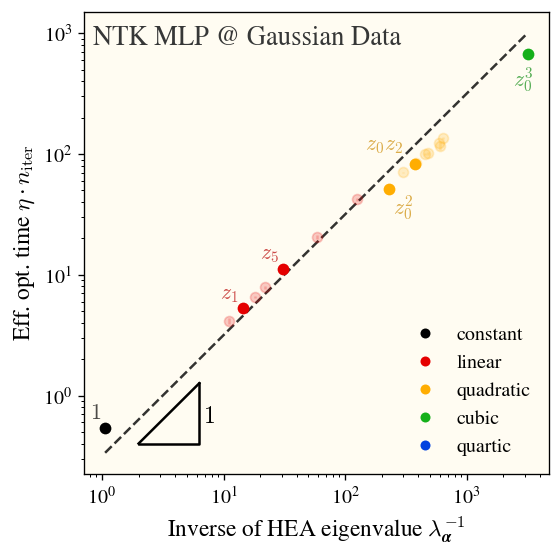

In [769]:
s = 6
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_ntk[-1]), axis=-1)*lr_base#*lr_ntk
breakpoints_std = (nanvar(torch.as_tensor(timekeys_ntk[-1]), axis=-1))**(0.5)*lr_base#*lr_ntk
breakpoints_means[-1] = breakpoints_means[-2]*(hea_eigvals[locs_ntk.long()].cpu()[-1]/hea_eigvals[locs_ntk.long()].cpu()[-2])**(-1.)

xaxis = ((hea_eigvals[locs_ntk.long()].cpu()))**(-1.)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_ntk.long()].cpu(), breakpoints_means.cpu(), targets_ntk,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(-0.5)*(xaxis)**(1.), color='k', linestyle='--', alpha=0.8)# label=f"")

#points
point_locs_ntk = [3, 3, 3, 0, 3, 0]

for idx, xi, yi in zip(noteable_locs_ntk, hea_eigvals[noteable_locs_ntk.long()]**(-1.), breakpoints_means[noteable_y_ntk.long()]):
    m = Monomial(monomials[idx.int().cpu().numpy()])
    if m in tags_ntk:
        color = colors[m.degree() % len(colors)]
        ax.scatter(xi, yi, color = color, alpha=1, zorder=10, s=s**2.)
        i = tags_ntk.index(monomials[idx.int().cpu().numpy()])
        kwargs = {"ha": "left" if point_locs_ntk[i] < 2 else "right",
                  "va": "bottom" if point_locs_ntk[i] % 2 == 1 else "top"}
        z = 0.08
        off = (
            z if point_locs_ntk[i] < 2 else -z,
            z if point_locs_ntk[i] % 2 == 1 else -z
        )
        if m == Monomial({0:1, 2:1}):
            # kwargs["ha"] = "center"
            off = (off[0]-.12, off[1]+0.08)
        elif m == Monomial({0:3}):
            off = (off[0]-.32, off[1]-.12)
        ax.annotate(str(m).replace('x', 'z'), (xi*(1+off[0]), yi*(1+off[1])), fontsize=13,
                    color=lighten(color, -0.2), alpha=0.7, **kwargs)
        
#triangle 
x0, y0 = 2, .4
dlogx = 0.5        
dlogy = 1 * dlogx 
x1 = x0 * 10**dlogx
y1 = y0 * 10**dlogy
dx = x1 - x0
dy = y1 - y0
x_coords = [x0, x1, x1]
y_coords = [y0, y0, y1]
ax.plot(x_coords, y_coords, 'k-')
ax.plot([x0, x1], [y0, y1], 'k-')  
ax.text(x0+dx*1.1, y0+dy*(np.log10(2)), r'$1$', 
         va='center', ha='left', fontsize=14)

color_handles = make_color_handles(colors, max_handle=4, s=s)
all_handles = color_handles
ax.legend(
        handles=all_handles,
        ncol=1,#2,
        loc="lower right",
        frameon=False,
        columnspacing=1.2,
        handletextpad=0.6,   
    )

ax.text(0.02, 0.97, f"NTK MLP @ Gaussian Data", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

ax.set_xlabel(r'Inverse of HEA eigenvalue $\lambda_{\boldsymbol{\alpha}}^{-1}$', fontsize=14)
ax.set_ylabel("Eff. opt. time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"NTK MLP @ Gaussian Data", fontsize=24)
plt.show()

## rich
seemingly unaffected

In [ ]:
timekeys_rich, targets_rich, num_trials_rich, _ = parse_timekeys_to_array(result_rich)
locs_rich = torch.zeros(len(targets_rich))

for i, monomial in enumerate(targets_rich):
    monomial = Monomial.from_repr(monomial)
    # print(np.where(np.array(monomials) == monomial))
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_rich[-1]), axis=-1)):
        break
    # print(loc)
    loc = np.where(np.array(monomials) == monomial)[0][0]
    locs_rich[i] = loc

In [ ]:
tags_rich = [{}, {1:1}, {5:1},
        {0:2}, {0:1,2:1}, {2:1, 3:1}, {1:1,10:1}, #{1:1,40:1},
        {1:3}, {0:1, 1:1, 2:1},
        {0:4}]
noteable_targets_rich = list(map(Monomial, tags_rich))
t2 = list(map(Monomial.from_repr, targets_rich))
noteable_locs_rich = torch.zeros(len(noteable_targets_rich))
noteable_y_rich = torch.zeros(len(noteable_targets_rich))

for i, monomial in enumerate(noteable_targets_rich):
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_rich[-1]), axis=-1)):
        break
    if monomial in monomials:
        loc = np.where(np.array(monomials) == monomial)[0][0]
        noteable_locs_rich[i] = loc
    if monomial in t2:
        loc = np.where(np.array(t2) == monomial)[0][0]
        noteable_y_rich[i] = loc
# noteable_targets_rich

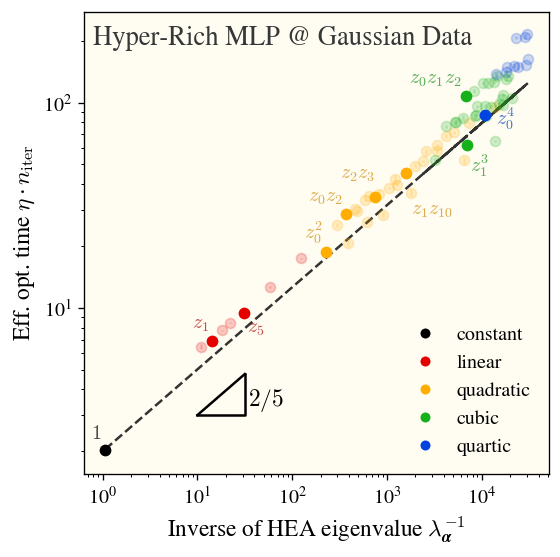

In [ ]:
s = 6
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_rich[-1]), axis=-1)*lr_base#*lr_rich
breakpoints_std = (nanvar(torch.as_tensor(timekeys_rich[-1]), axis=-1))**(0.5)*lr_base#*lr_rich

xaxis = ((hea_eigvals[locs_rich.long()].cpu()))**(-1.)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_rich.long()].cpu(), breakpoints_means.cpu(), targets_rich,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(.3)*(xaxis)**(.4), color='k', linestyle='--', alpha=0.8)# label=f"")

point_locs_rich = [3, 3, 0, 3, 3, 3, 0, 0, 3, 0,]

for idx, xi, yi in zip(noteable_locs_rich, hea_eigvals[noteable_locs_rich.long()]**(-1.), breakpoints_means[noteable_y_rich.long()]):
    m = Monomial(monomials[idx.int().cpu().numpy()])
    if m in tags_rich:
        color = colors[m.degree() % len(colors)]
        ax.scatter(xi, yi, color = color, alpha=1, zorder=10, s=s**2.)
        i = tags_rich.index(monomials[idx.int().cpu().numpy()])
        kwargs = {"ha": "left" if point_locs_rich[i] < 2 else "right",
                  "va": "bottom" if point_locs_rich[i] % 2 == 1 else "top"}
        z = 0.08
        off = (
            z if point_locs_rich[i] < 2 else -z,
            z if point_locs_rich[i] % 2 == 1 else -z
        )
        if m == Monomial({3:2, 5:1}):
            kwargs["ha"] = "center"
            off = (off[0]+0.2, off[1]+0.04)
        elif m == Monomial({3:1, 5:2}):
            kwargs["ha"] = "center"
            off = (off[0]-.08, off[1]-.28)
        elif m == Monomial({2:1, 3:1}):
            kwargs["ha"] = "right"
            off = (off[0]+0.08, off[1]+0.08)
        elif m == Monomial({1:1, 10:1}):
            kwargs["ha"] = "left"
            kwargs["va"] = "top"
            off = (off[0]+.07, off[1]-.2)
        elif m == Monomial({1:3}):
            off = (off[0], off[1])
        elif m == Monomial({0:1, 1:1, 2:1, 3:1}):
            kwargs["ha"] = "right"
            off = (off[0]-.2, off[1]-.32)
        elif m == Monomial({0:4}):
            # kwargs["ha"] = "right"
            off = (off[0]+.22, off[1]+.2)
        ax.annotate(str(m).replace('x', 'z'), (xi*(1+off[0]), yi*(1+off[1])), fontsize=fsize,
                    color=lighten(color, -0.2), alpha=0.7, **kwargs)
        
#triangle 
x0, y0 = 10, 3
dlogx = 0.5        
dlogy = 0.4 * dlogx 
x1 = x0 * 10**dlogx
y1 = y0 * 10**dlogy
dx = x1 - x0
dy = y1 - y0
x_coords = [x0, x1, x1]
y_coords = [y0, y0, y1]
ax.plot(x_coords, y_coords, 'k-')
ax.plot([x0, x1], [y0, y1], 'k-')  
ax.text(x0+dx*1.1, y0+dy*(np.log10(2)), r'$2/5$', 
         va='center', ha='left', fontsize=14)

color_handles = make_color_handles(colors, max_handle=4, s=s)
all_handles = color_handles
ax.legend(
        handles=all_handles,
        ncol=1,#2,
        loc="lower right",
        frameon=False,
        columnspacing=1.2,
        handletextpad=0.6,   
    )

ax.text(0.02, 0.97, f"Hyper-Rich MLP @ Gaussian Data", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

ax.set_xlabel(r'Inverse of HEA eigenvalue $\lambda_{\boldsymbol{\alpha}}^{-1}$', fontsize=14)
ax.set_ylabel("Eff. opt. time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"NTK MLP @ Gaussian Data", fontsize=24)
plt.show()

# CIFAR

In [ ]:
import json
from pathlib import Path

from feature_decomp import Monomial  # or: from modelscape.data.monomial import Monomial

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

cifar_data_eigvals = torch.tensor(load_json("cifar_data_eigvals.json"), dtype=torch.float)
cifar_hea_eigvals  = torch.tensor(load_json("cifar_hea_eigvals.json"), dtype=torch.float)

mon_repr = load_json("cifar_monomials.json")  # list of strings like "$x_{0}^2$"
cifar_monomials = np.array([Monomial.from_repr(m) for m in mon_repr], dtype=object)

c = {
    0: 0.9423311143775628,
    1: 0.7585548159036320,
    2: 0.3062938307898845,
    3: 0.1837762984739307,
    4: 0.4492309518251639,
    5: 1.3749189737679260,
    6: 5.9352937877506510,
}

cifar_raw_eigvals = []
for m, v in zip(cifar_monomials, cifar_hea_eigvals):
    d = m.degree()
    if d not in c:
        raise ValueError(f"degree {d} not supported (only 0..4)")
    cifar_raw_eigvals.append(v / c[d])
cifar_raw_eigvals = torch.tensor(cifar_raw_eigvals)

## cifar stuff

### cifar text

In [ ]:
exptpath = os.getenv("EXPTPATH")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", "mlp-learning", "synthetic")

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)
result_cifar = expt_fm.load("result.pickle")
lr_cifar=5e-2

### cifar grabs

In [ ]:
timekeys_cifar, targets_cifar, num_trials_cifar, _ = parse_timekeys_to_array(result_cifar)
locs_cifar = torch.zeros(len(targets_cifar))

for i, monomial in enumerate(targets_cifar):
    monomial = Monomial.from_repr(monomial)
    # print(np.where(np.array(cifar_monomials) == monomial))
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_cifar[-1]), axis=-1)):
        break
    # print(loc)
    loc = np.where(np.array(cifar_monomials) == monomial)[0][0]
    locs_cifar[i] = loc

In [ ]:
tags_cifar = [{}, {1:1}, {0:2}, {5:1}, {0:1,2:1}, {40:1},
        {2:1, 3:1}, {1:3}, {150:1}, #{1:1,40:1},
        {1:1, 60:1},  {0:2, 5:1}]

noteable_targets_cifar = list(map(Monomial, tags_cifar))
t2 = list(map(Monomial.from_repr, targets_cifar))
noteable_locs_cifar = torch.ones(len(noteable_targets_cifar))
noteable_y_cifar = torch.ones(len(noteable_targets_cifar))

for i, monomial in enumerate(noteable_targets_cifar):
    if i >= len(torch.nanmean(torch.as_tensor(timekeys_cifar[-1]), axis=-1)):
        break
    if monomial in cifar_monomials:
        loc = np.where(np.array(cifar_monomials) == monomial)[0][0]
        noteable_locs_cifar[i] = loc
    if monomial in t2:
        loc = np.where(np.array(t2) == monomial)[0][0]
        noteable_y_cifar[i] = loc
# noteable_targets_cifar

In [ ]:
s = 6
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_cifar[-1]), axis=-1)*lr_cifar
breakpoints_std = (nanvar(torch.as_tensor(timekeys_cifar[-1]), axis=-1))**(0.5)*lr_cifar

xaxis = torch.sort(((cifar_hea_eigvals[locs_cifar.long()].cpu()))**(-1.)).values

plot_time_to_learn_eigenvalue_lightened_ax(ax, cifar_hea_eigvals[locs_cifar.long()].cpu(), breakpoints_means.cpu(), targets_cifar,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(1.)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")

#points
point_locs_cifar = [3, 3, 3, 0,
        0, 0, 3, 3, 3,
        3, 0]

for idx, xi, yi in zip(noteable_locs_cifar, cifar_hea_eigvals[noteable_locs_cifar.long()]**(-1.), breakpoints_means[noteable_y_cifar.long()]):
    if yi == breakpoints_means[1]:
        continue
    m = Monomial(cifar_monomials[idx.int().cpu().numpy()])
    ax.scatter(xi, yi, color = colors[m.degree()%7], alpha=1, zorder=10, s=s**2.)
    color = colors[m.degree() % len(colors)]
    if m in tags_cifar:
        i = tags_cifar.index(cifar_monomials[idx.int().cpu().numpy()])
        kwargs = {"ha": "left" if point_locs_cifar[i] < 2 else "right",
                  "va": "bottom" if point_locs_cifar[i] % 2 == 1 else "top"}
        z = 0.08
        off = (
            z if point_locs_cifar[i] < 2 else -z,
            z if point_locs_cifar[i] % 2 == 1 else -z
        )
        if m == Monomial({1:3}):
            kwargs["ha"] = "center"
            off = (off[0]-0.48, off[1]+0.32)
        elif m == Monomial({150:1}):
            kwargs["ha"] = "center"
            off = (off[0], off[1]+.24)
        elif m == Monomial({0:2, 5:1}):
            # kwargs["ha"] = "right"
            off = (off[0]+.64, off[1]-0.08)
        elif m == Monomial({1:1, 60:1}):
            # kwargs["ha"] = "left"
            # kwargs["va"] = "top"
            off = (off[0], off[1]+.1)
        # elif m == Monomial({0:1, 1:1, 2:1, 3:1}):
        #     kwargs["ha"] = "right"
        #     off = (off[0], off[1]-.08)
        ax.annotate(str(m).replace('x', 'z'), (xi*(1+off[0]), yi*(1+off[1])), fontsize=13,
                    color=lighten(color, -0.2), alpha=0.7, **kwargs)
        

#triangle 
x0, y0 = 7, 12
dlogx = 1.3        
dlogy = 0.5 * dlogx 
x1 = x0 * 10**dlogx
y1 = y0 * 10**dlogy
dx = x1 - x0
dy = y1 - y0
x_coords = [x0, x1, x1]
y_coords = [y0, y0, y1]
ax.plot(x_coords, y_coords, 'k-', linewidth=0.5)
ax.plot([x0, x1], [y0, y1], 'k-', linewidth=0.5)  
ax.text(x0+dx*1.1, y0+dy*(np.log10(2)), r'$1/2$', 
         va='center', ha='left', fontsize=13, fontweight="light")

ax.text(0.02, 0.97, f"MLP @ CIFAR5m", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

color_handles = make_color_handles(colors, max_handle=3, s=s)
all_handles = color_handles
ax.legend(
        handles=all_handles,
        ncol=1,#2,
        loc="lower right",
        frameon=False,
        columnspacing=1.2,
        handletextpad=0.6,   
    )

ax.set_xlabel('Inverse of HEA eigenvalue $\\lambda_{{\\alpha}}^{{-1}}$', fontsize=14)
ax.set_ylabel("Effective optimization time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
# plt.legend()
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()

# megaplot

## main fig

In [885]:
import matplotlib.transforms as mtransforms

def _dy_pixels_to_data(ax, x, y, dy_px):
    # Make sure transforms are current
    ax.figure.canvas.draw()
    p0x, p0y = ax.transData.transform((x, y))
    y1 = ax.transData.inverted().transform((p0x, p0y + dy_px))[1]
    return y1 - y  # data-space delta-y corresponding to dy_px

def triangle_y0_with_pixel_gap(ax, x0, A, m, gap_px):
    y_line = A * (x0**m)
    return y_line + _dy_pixels_to_data(ax, x0, y_line, gap_px)


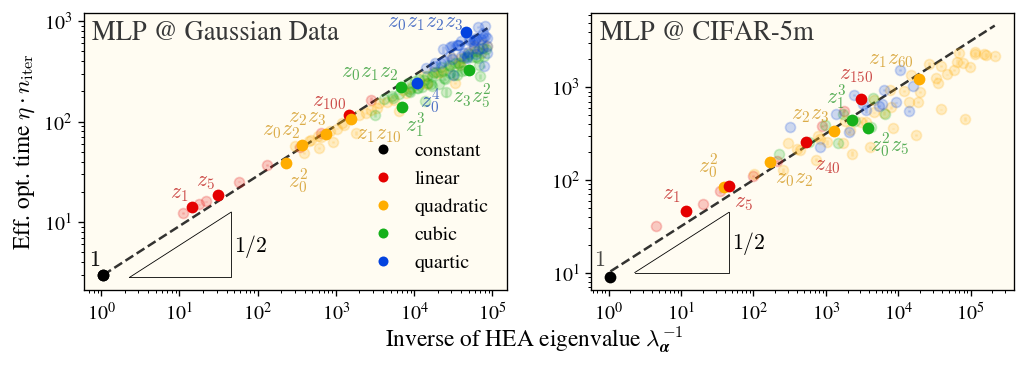

In [896]:
s = 6
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

ax = axes[0]

breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)*lr_base
breakpoints_std = (nanvar(torch.as_tensor(timekeys_base[-1]), axis=-1))**(0.5)*lr_base

xaxis = ((hea_eigvals[locs_base.long()].cpu()))**(-1.)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_base.long()].cpu(), breakpoints_means.cpu(), targets_base,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")

#points
point_locs_base = [3, 3, 3, 3,
        3, 0, 3, 3, 0,
        0, 3, 0,
        0, 3]

for idx, xi, yi in zip(noteable_locs_base, hea_eigvals[noteable_locs_base.long()]**(-1.), breakpoints_means[noteable_y_base.long()]):
    m = Monomial(monomials[idx.int().cpu().numpy()])
    if m in tags_base:
        color = colors[m.degree() % len(colors)]
        ax.scatter(xi, yi, color = color, alpha=1, zorder=10, s=s**2.)
        i = tags_base.index(monomials[idx.int().cpu().numpy()])
        kwargs = {"ha": "left" if point_locs_base[i] < 2 else "right",
                  "va": "bottom" if point_locs_base[i] % 2 == 1 else "top"}
        z = 0.08
        off = (
            z if point_locs_base[i] < 2 else -z,
            z if point_locs_base[i] % 2 == 1 else -z
        )
        if m == Monomial({3:2, 5:1}):
            kwargs["ha"] = "center"
            off = (off[0]+0.28, off[1]+0.04)
        elif m == Monomial({3:1, 5:2}):
            kwargs["ha"] = "center"
            off = (off[0], off[1]-.14)
        elif m == Monomial({2:1, 3:1}):
            kwargs["ha"] = "right"
            off = (off[0]+0.08, off[1]+0.08)
        elif m == Monomial({1:1, 10:1}):
            kwargs["ha"] = "left"
            kwargs["va"] = "top"
            off = (off[0]+.07, off[1]-.04)
        elif m == Monomial({0:1, 1:1, 2:1, 3:1}):
            kwargs["ha"] = "right"
            off = (off[0], off[1]-.08)
        ax.annotate(str(m).replace('x', 'z'), (xi*(1+off[0]), yi*(1+off[1])), fontsize=13,
                    color=lighten(color, -0.2), alpha=0.7, **kwargs)
        
y0_1 = triangle_y0_with_pixel_gap(ax, 0.5, 10**(0.46), 0.5, 14) #3
make_triangle(ax, x=6, y0=y0_1, dlogx=1.3, slope=0.5)

ax.text(0.02, 0.97, f"MLP @ Gaussian Data", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

color_handles = make_color_handles(colors, max_handle=4, s=s)
all_handles = color_handles
ax.legend(
        handles=all_handles,
        ncol=1,#2,
        loc="lower right",
        frameon=False,
        columnspacing=1.2,
        handletextpad=0.6,   
    )

# ax.set_xlabel(r'Inverse of HEA eigenvalue $\lambda_{\boldsymbol{\alpha}}^{-1}$', fontsize=14)
ax.set_ylabel("Eff. opt. time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')

# big_exponent_logticks(ax, axis='x', exp_scale=1.1, dx=1, dy=1)



ax = axes[1]

breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_cifar[-1]), axis=-1)*lr_cifar
breakpoints_std = (nanvar(torch.as_tensor(timekeys_cifar[-1]), axis=-1))**(0.5)*lr_cifar

xaxis = torch.sort(((cifar_hea_eigvals[locs_cifar.long()].cpu()))**(-1.)).values

plot_time_to_learn_eigenvalue_lightened_ax(ax, cifar_hea_eigvals[locs_cifar.long()].cpu(), breakpoints_means.cpu(), targets_cifar,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(1.)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")

#points
point_locs_cifar = [3, 3, 3, 0,
        0, 0, 3, 3, 3,
        3, 0]

for idx, xi, yi in zip(noteable_locs_cifar, cifar_hea_eigvals[noteable_locs_cifar.long()]**(-1.), breakpoints_means[noteable_y_cifar.long()]):
    m = Monomial(cifar_monomials[idx.int().cpu().numpy()])
    if m in tags_cifar:
        color = colors[m.degree() % len(colors)]
        ax.scatter(xi, yi, color = color, alpha=1, zorder=10, s=s**2.)
        i = tags_cifar.index(cifar_monomials[idx.int().cpu().numpy()])
        kwargs = {"ha": "left" if point_locs_cifar[i] < 2 else "right",
                  "va": "bottom" if point_locs_cifar[i] % 2 == 1 else "top"}
        z = 0.16
        off = (
            z if point_locs_cifar[i] < 2 else -z,
            z if point_locs_cifar[i] % 2 == 1 else -z
        )
        if m == Monomial({1:3}):
            kwargs["ha"] = "center"
            off = (off[0]-0.48, off[1]+0.32)
        elif m == Monomial({150:1}):
            kwargs["ha"] = "center"
            off = (off[0], off[1]+.24)
        elif m == Monomial({40:1}):
            # kwargs["ha"] = "center"
            off = (off[0]+.12, off[1]-.14)
        elif m == Monomial({0:2, 5:1}):
            # kwargs["ha"] = "right"
            off = (off[0]+.64, off[1]-0.08)
        elif m == Monomial({1:1, 60:1}):
            # kwargs["ha"] = "left"
            # kwargs["va"] = "top"
            off = (off[0], off[1]+.1)
        # elif m == Monomial({0:1, 1:1, 2:1, 3:1}):
        #     kwargs["ha"] = "right"
        #     off = (off[0], off[1]-.08)
        ax.annotate(str(m).replace('x', 'z'), (xi*(1+off[0]), yi*(1+off[1])), fontsize=13,
                    color=lighten(color, -0.2), alpha=0.7, **kwargs)
        
y0_2 = triangle_y0_with_pixel_gap(ax, 0.5, 10**(1.), 0.5, 14) #12
make_triangle(ax, x=6, y0=y0_2, dlogx=1.3, slope=0.5)

ax.text(0.02, 0.97, f"MLP @ CIFAR-5m", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

# color_handles = make_color_handles(colors, max_handle=3, s=s)
# all_handles = color_handles
# ax.legend(
#         handles=all_handles,
#         ncol=1,#2,
#         loc="lower right",
#         frameon=False,
#         columnspacing=1.2,
#         handletextpad=0.6,   
#     )

ax.set_xscale('log')
ax.set_yscale('log')
# plt.legend()
# xlbl = fig.supxlabel('Inverse of HEA eigenvalue $\\lambda_{{\\alpha}}^{{-1}}$', y=0.01, fontsize=14)
xlbl = fig.supxlabel(r'Inverse of HEA eigenvalue $\lambda_{\boldsymbol{\alpha}}^{-1}$', y=0.01, fontsize=14)
xlbl.set_y(-0.07)
# fig.supylabel("Effective optimization time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=12)
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
# big_exponent_logticks(ax, axis='x', exp_scale=1.2, dx=1.2, dy=1.2)

# plt.show()
plt.savefig("fig5.pdf", bbox_inches='tight', dpi=300)

## across params

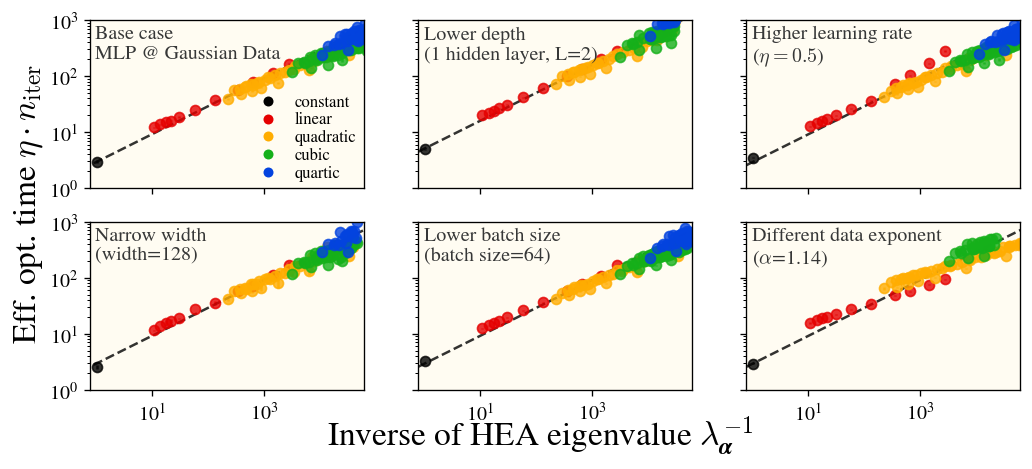

In [895]:
s = 6
fsize = 12
titlesize = 12
fig, axes = plt.subplots(2, 3, figsize=(10, 4), sharex=True, sharey=True)

ax = axes[0, 0]

breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)*lr_base
breakpoints_std = (nanvar(torch.as_tensor(timekeys_base[-1]), axis=-1))**(0.5)*lr_base

xaxis = np.logspace(-2, 6, 20)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_base.long()].cpu(), breakpoints_means.cpu(), targets_base,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.8, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")

ax.text(0.02, 0.97, f"Base case\nMLP @ Gaussian Data", ha="left", va="top",
        transform=ax.transAxes, fontsize=titlesize, color="xkcd:dark gray")

color_handles = make_color_handles(colors, max_handle=4, s=s)
all_handles = color_handles
ax.legend(
        handles=all_handles,
        ncol=1,#2,
        loc="lower right",
        frameon=False,
        columnspacing=1.2,
        handletextpad=0.6, 
        labelspacing=0.1,  
        fontsize=10,
        handleheight=0.4,
        borderaxespad = 0.05, 
    )

ax.set_xscale('log')
ax.set_yscale('log')

# ------------------------------------------------------------------------------------------------------------------------------

ax = axes[0, 1]

breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_depth[-1]), axis=-1)*lr_depth
breakpoints_std = (nanvar(torch.as_tensor(timekeys_depth[-1]), axis=-1))**(0.5)*lr_depth

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_depth.long()].cpu(), breakpoints_means.cpu(), targets_depth,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.8, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(0.7)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")

ax.text(0.02, 0.97, f"Lower depth\n(1 hidden layer, L=2)", ha="left", va="top",
        transform=ax.transAxes, fontsize=titlesize, color="xkcd:dark gray")


ax.set_xscale('log')
ax.set_yscale('log')

# ------------------------------------------------------------------------------------------------------------------------------

ax = axes[0, 2]

breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_lr[-1]), axis=-1)*lr_lr
breakpoints_std = (nanvar(torch.as_tensor(timekeys_lr[-1]), axis=-1))**(0.5)*lr_lr

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_lr.long()].cpu(), breakpoints_means.cpu(), targets_lr,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.8, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")     

ax.text(0.02, 0.97, f"Higher learning rate\n($\\eta=0.5$)", ha="left", va="top",
        transform=ax.transAxes, fontsize=titlesize, color="xkcd:dark gray")


ax.set_xscale('log')
ax.set_yscale('log')

# ------------------------------------------------------------------------------------------------------------------------------

ax = axes[1, 0]

s = 6
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_width[-1]), axis=-1)*lr_width
breakpoints_std = (nanvar(torch.as_tensor(timekeys_width[-1]), axis=-1))**(0.5)*lr_width

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_width.long()].cpu(), breakpoints_means.cpu(), targets_width,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.8, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")
        
ax.text(0.02, 0.97, f"Narrow width\n(width=128)", ha="left", va="top",
        transform=ax.transAxes, fontsize=titlesize, color="xkcd:dark gray")

ax.set_xscale('log')
ax.set_yscale('log')

# ------------------------------------------------------------------------------------------------------------------------------

ax = axes[1, 1]

breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_bsz[-1]), axis=-1)*lr_bsz
breakpoints_std = (nanvar(torch.as_tensor(timekeys_bsz[-1]), axis=-1))**(0.5)*lr_bsz

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_bsz.long()].cpu(), breakpoints_means.cpu(), targets_bsz,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.8, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")

ax.text(0.02, 0.97, f"Lower batch size\n(batch size=64)", ha="left", va="top",
        transform=ax.transAxes, fontsize=titlesize, color="xkcd:dark gray")

ax.set_xscale('log')
ax.set_yscale('log')

# ------------------------------------------------------------------------------------------------------------------------------

ax = axes[1, 2]

breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_alpha[-1]), axis=-1)*lr_alpha
breakpoints_std = (nanvar(torch.as_tensor(timekeys_alpha[-1]), axis=-1))**(0.5)*lr_alpha

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_alpha.long()].cpu(), breakpoints_means.cpu(), targets_alpha,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.8, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")

#points
point_locs_alpha = [3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# for idx, xi, yi in zip(noteable_locs_alpha, hea_eigvals[noteable_locs_alpha.long()]**(-1.), breakpoints_means[noteable_y_alpha.long()]):
#     m = Monomial(monomials[idx.int().cpu().numpy()])
#     if m in tags_alpha:
#         color = colors[m.degree() % len(colors)]
#         ax.scatter(xi, yi, color = color, alpha=1, zorder=10, s=s**2.)
#         i = tags_alpha.index(monomials[idx.int().cpu().numpy()])
#         kwargs = {"ha": "left" if point_locs_alpha[i] < 2 else "right",
#                   "va": "bottom" if point_locs_alpha[i] % 2 == 1 else "top"}
#         z = 0.08
#         off = (
#             z if point_locs_alpha[i] < 2 else -z,
#             z if point_locs_alpha[i] % 2 == 1 else -z
#         )
#         ax.annotate(str(m).replace('x', 'z'), (xi*(1+off[0]), yi*(1+off[1])), fontsize=fsize,
#                     color=lighten(color, -0.2), alpha=0.7, **kwargs)
        

ax.text(0.02, 0.97, f"Different data exponent\n($\\alpha$=1.14)", ha="left", va="top",
        transform=ax.transAxes, fontsize=titlesize, color="xkcd:dark gray")


ax.set_xscale('log')
ax.set_yscale('log')

# ------------------------------------------------------------------------------------------------------------------------------

# xlbl = fig.supxlabel('Inverse of HEA eigenvalue $\\lambda_{{\\alpha}}^{{-1}}$', y=0.01, fontsize=20)
xlbl = fig.supxlabel(r'Inverse of HEA eigenvalue $\lambda_{\boldsymbol{\alpha}}^{-1}$', y=0.01, fontsize=20)
ylbl = fig.supylabel("Eff. opt. time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=20)
xlbl.set_y(-0.03)
ylbl.set_x(0.06)

axes[0,0].set_xlim(1-.2, 6e4)
axes[0,0].set_ylim(1, 1e3)
# fig.supylabel("Effective optimization time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=12)
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
# big_exponent_logticks(ax, axis='x', exp_scale=1.2, dx=1.2, dy=1.2)

# plt.show()
plt.savefig("hyperparam_sweep.pdf", bbox_inches='tight', dpi=300)

## across FL strength

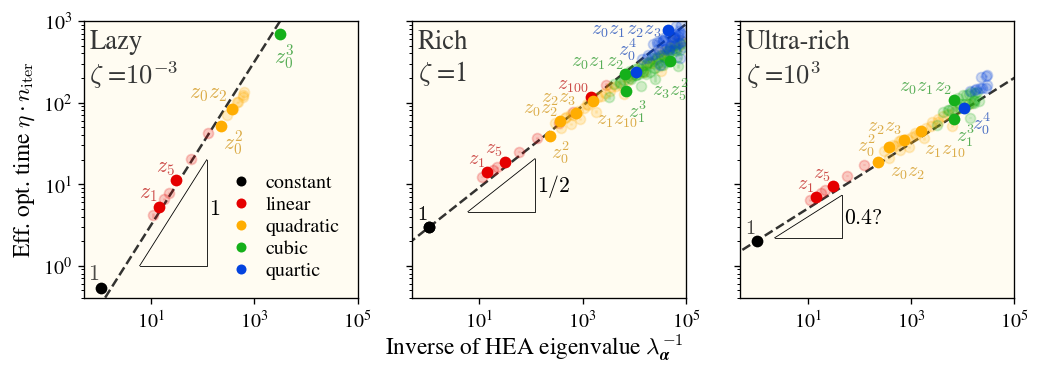

In [894]:
s = 6
fsize = 12
titlesize = 16
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)

ax = axes[1]

breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)*lr_base
breakpoints_std = (nanvar(torch.as_tensor(timekeys_base[-1]), axis=-1))**(0.5)*lr_base

xaxis = np.logspace(-2, 6, 20)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_base.long()].cpu(), breakpoints_means.cpu(), targets_base,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle='--', alpha=0.8)# label=f"")

#points
point_locs_base = [3, 3, 3, 3,
        3, 0, 3, 3, 0,
        0, 3, 0,
        3, 3]

for idx, xi, yi in zip(noteable_locs_base, hea_eigvals[noteable_locs_base.long()]**(-1.), breakpoints_means[noteable_y_base.long()]):
    m = Monomial(monomials[idx.int().cpu().numpy()])
    if m in tags_base:
        color = colors[m.degree() % len(colors)]
        ax.scatter(xi, yi, color = color, alpha=1, zorder=10, s=s**2.)
        i = tags_base.index(monomials[idx.int().cpu().numpy()])
        kwargs = {"ha": "left" if point_locs_base[i] < 2 else "right",
                  "va": "bottom" if point_locs_base[i] % 2 == 1 else "top"}
        z = 0.08
        off = (
            z if point_locs_base[i] < 2 else -z,
            z if point_locs_base[i] % 2 == 1 else -z
        )
        if m == Monomial({3:2, 5:1}):
            kwargs["ha"] = "center"
            off = (off[0]+0.2, off[1]+0.04)
        elif m == Monomial({3:1, 5:2}):
            kwargs["ha"] = "center"
            off = (off[0]-.08, off[1]-.28)
        elif m == Monomial({2:1, 3:1}):
            kwargs["ha"] = "right"
            off = (off[0]+0.08, off[1]+0.08)
        elif m == Monomial({1:1, 10:1}):
            kwargs["ha"] = "left"
            kwargs["va"] = "top"
            off = (off[0]+.07, off[1]-.2)
        elif m == Monomial({1:3}):
            off = (off[0], off[1]-.12)
        elif m == Monomial({0:1, 1:1, 2:1, 3:1}):
            kwargs["ha"] = "right"
            off = (off[0]-.2, off[1]-.32)
        elif m == Monomial({0:4}):
            # kwargs["ha"] = "right"
            off = (off[0]+.12, off[1]+.2)
        ax.annotate(str(m).replace('x', 'z'), (xi*(1+off[0]), yi*(1+off[1])), fontsize=fsize,
                    color=lighten(color, -0.2), alpha=0.7, **kwargs)

#triangle 
x0, y0 = 6, 4.6
dlogx = 1.3        
dlogy = 0.5 * dlogx 
x1 = x0 * 10**dlogx
y1 = y0 * 10**dlogy
dx = x1 - x0
dy = y1 - y0
x_coords = [x0, x1, x1]
y_coords = [y0, y0, y1]
ax.plot(x_coords, y_coords, 'k-', linewidth=0.5)
ax.plot([x0, x1], [y0, y1], 'k-', linewidth=0.5)  
ax.text(x0+dx*1.1, y0+dy*(np.log10(2)), r'$1/2$', 
         va='center', ha='left', fontsize=13, fontweight="light")

ax.text(0.02, 0.97, f"Rich\n$\\zeta$ =1", ha="left", va="top",
        transform=ax.transAxes, fontsize=titlesize, color="xkcd:dark gray")

ax = axes[0]

breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_ntk[-1]), axis=-1)*lr_base#*lr_ntk
breakpoints_std = (nanvar(torch.as_tensor(timekeys_ntk[-1]), axis=-1))**(0.5)*lr_base#*lr_ntk

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_ntk.long()].cpu(), breakpoints_means.cpu(), targets_ntk,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(-0.5)*(xaxis)**(1.), color='k', linestyle='--', alpha=0.8)# label=f"")

#points
point_locs_ntk = [3, 3, 3, 0, 3, 0]

for idx, xi, yi in zip(noteable_locs_ntk, hea_eigvals[noteable_locs_ntk.long()]**(-1.), breakpoints_means[noteable_y_ntk.long()]):
    m = Monomial(monomials[idx.int().cpu().numpy()])
    if m in tags_ntk:
        color = colors[m.degree() % len(colors)]
        ax.scatter(xi, yi, color = color, alpha=1, zorder=10, s=s**2.)
        i = tags_ntk.index(monomials[idx.int().cpu().numpy()])
        kwargs = {"ha": "left" if point_locs_ntk[i] < 2 else "right",
                  "va": "bottom" if point_locs_ntk[i] % 2 == 1 else "top"}
        z = 0.08
        off = (
            z if point_locs_ntk[i] < 2 else -z,
            z if point_locs_ntk[i] % 2 == 1 else -z
        )
        if m == Monomial({0:1, 2:1}):
            # kwargs["ha"] = "center"
            off = (off[0]-.12, off[1]+0.08)
        elif m == Monomial({0:3}):
            off = (off[0]-.32, off[1]-.12)
        ax.annotate(str(m).replace('x', 'z'), (xi*(1+off[0]), yi*(1+off[1])), fontsize=13,
                    color=lighten(color, -0.2), alpha=0.7, **kwargs)
        
#triangle 
x0, y0 = 6, 1
dlogx = 1.3        
dlogy = 1 * dlogx 
x1 = x0 * 10**dlogx
y1 = y0 * 10**dlogy
dx = x1 - x0
dy = y1 - y0
x_coords = [x0, x1, x1]
y_coords = [y0, y0, y1]
ax.plot(x_coords, y_coords, 'k-', linewidth=0.5)
ax.plot([x0, x1], [y0, y1], 'k-', linewidth=0.5)  
ax.text(x0+dx*1.1, y0+dy*(.2), r'$1$', 
         va='center', ha='left', fontsize=13, fontweight="light")

color_handles = make_color_handles(colors, max_handle=4, s=s)
all_handles = color_handles
ax.legend(
        handles=all_handles,
        ncol=1,#2,
        loc="lower right",
        frameon=False,
        columnspacing=0.8,
        handletextpad=0.2,
        labelspacing=0.2,   
    )

ax.text(0.02, 0.97, f"Lazy\n$\\zeta$ =$10^{{-3}}$", ha="left", va="top",
        transform=ax.transAxes, fontsize=titlesize, color="xkcd:dark gray")
ax.set_ylabel("Eff. opt. time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=14)

ax = axes[2]

breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_rich[-1]), axis=-1)*lr_base#*lr_rich
breakpoints_std = (nanvar(torch.as_tensor(timekeys_rich[-1]), axis=-1))**(0.5)*lr_base#*lr_rich


plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_rich.long()].cpu(), breakpoints_means.cpu(), targets_rich,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s)
# solid line along emp points
ax.plot(xaxis, 10**(.3)*(xaxis)**(.4), color='k', linestyle='--', alpha=0.8)# label=f"")


point_locs_rich = [3, 3, 3, 3, 0, 3, 0, 0, 3, 0,]

for idx, xi, yi in zip(noteable_locs_rich, hea_eigvals[noteable_locs_rich.long()]**(-1.), breakpoints_means[noteable_y_rich.long()]):
    m = Monomial(monomials[idx.int().cpu().numpy()])
    if m in tags_rich:
        color = colors[m.degree() % len(colors)]
        ax.scatter(xi, yi, color = color, alpha=1, zorder=10, s=s**2.)
        i = tags_rich.index(monomials[idx.int().cpu().numpy()])
        kwargs = {"ha": "left" if point_locs_rich[i] < 2 else "right",
                  "va": "bottom" if point_locs_rich[i] % 2 == 1 else "top"}
        z = 0.08
        off = (
            z if point_locs_rich[i] < 2 else -z,
            z if point_locs_rich[i] % 2 == 1 else -z
        )
        if m == Monomial({1:1, 10:1}):
            kwargs["ha"] = "left"
            kwargs["va"] = "top"
            off = (off[0]+.07, off[1]-.2)
        elif m == Monomial({0:1, 2:1}):
            off = (off[0], off[1]-.32)
        elif m == Monomial({0:4}):
            off = (off[0]+.32, off[1])
        ax.annotate(str(m).replace('x', 'z'), (xi*(1+off[0]), yi*(1+off[1])), fontsize=fsize,
                    color=lighten(color, -0.2), alpha=0.7, **kwargs)
        
#triangle 
x0, y0 = 2.3, 2.2
dlogx = 1.3        
dlogy = 0.4 * dlogx 
x1 = x0 * 10**dlogx
y1 = y0 * 10**dlogy
dx = x1 - x0
dy = y1 - y0
x_coords = [x0, x1, x1]
y_coords = [y0, y0, y1]
ax.plot(x_coords, y_coords, 'k-', linewidth=0.5)
ax.plot([x0, x1], [y0, y1], 'k-', linewidth=0.5)  
ax.text(x0+dx*1.1, y0+dy*(np.log10(2)), r'$0.4?$', 
         va='center', ha='left', fontsize=13, fontweight="light")

ax.set_xscale('log')
ax.set_yscale('log')

ax.text(0.02, 0.97, f"Ultra-rich\n$\\zeta$ =$10^{{3}}$", ha="left", va="top",
        transform=ax.transAxes, fontsize=titlesize, color="xkcd:dark gray")

# ax.set_xlabel('Inverse of HEA eigenvalue $\\lambda_{{\\alpha}}^{{-1}}$', y=0.01, fontsize=18)
xlbl = fig.supxlabel(r'Inverse of HEA eigenvalue $\lambda_{\boldsymbol{\alpha}}^{-1}$', fontsize=14)

# xlbl = fig.supxlabel('Inverse of HEA eigenvalue $\\lambda_{{\\boldsymbol{{\\alpha}}}}^{{-1}}$', fontsize=14)
# fig.supylabel("Eff. opt. time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=24)
xlbl.set_y(-0.07)
# fig.supylabel("Effective optimization time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=12)
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
# big_exponent_logticks(ax, axis='x', exp_scale=1.2, dx=1.2, dy=1.2)
axes[0].set_xlim(1-.5, 1e5)
axes[0].set_ylim(1-.6, 1e3)

# plt.show()
plt.savefig("richness_sweep.pdf", bbox_inches='tight', dpi=300)

# scratch

In [ ]:
s = 6
linestyles = [
    '--',   # dashed
    '-',    # solid
    '-.',   # dash-dot
    ':',    # dotted
    (0, (3, 5, 1, 5)),  # custom dash pattern (dash-dot-dot)
]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_depth[-1]), axis=-1)*lr_depth
breakpoints_std = (nanvar(torch.as_tensor(timekeys_depth[-1]), axis=-1))**(0.5)*lr_depth

xaxis = ((hea_eigvals[locs_depth.long()].cpu()))**(-1.)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_depth.long()].cpu(), breakpoints_means.cpu(), targets_depth,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s, marker_index=0)
# solid line along emp points
ax.plot(xaxis, 10**(0.7)*(xaxis)**(0.5), color='k', linestyle=linestyles[0], alpha=0.8, label=f"1 Hidden layer")

#points
locs = [3, 3, 3, 3,
        3, 0, 3, 3, 0,
        0, 3, 0,
        0, 3]
        

s = 6
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_base[-1]), axis=-1)*lr_base
breakpoints_std = ((nanvar(torch.as_tensor(timekeys_base[-1]), axis=-1))**(0.5))*lr_base

# xaxis = ((hea_eigvals[locs_base.long()][:len(timekeys_depth)].cpu()))**(-1.)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_base.long()].cpu(), breakpoints_means.cpu(), targets_depth,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s, marker_index=2)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle=linestyles[1], alpha=0.8, label=f"Base case")

#points
locs = [3, 3, 3, 3,
        3, 0, 3, 3, 0,
        0, 3, 0,
        0, 3]

s = 6
breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_width[-1]), axis=-1)*lr_width
breakpoints_std = ((nanvar(torch.as_tensor(timekeys_width[-1]), axis=-1))**(0.5))*lr_width

# xaxis = ((hea_eigvals[locs_base.long()][:len(timekeys_depth)].cpu()))**(-1.)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_width.long()].cpu(), breakpoints_means.cpu(), targets_width,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s, marker_index=1)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle=linestyles[2], alpha=0.8, label=f"Width 128")



breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_lr[-1]), axis=-1)*lr_lr
breakpoints_std = ((nanvar(torch.as_tensor(timekeys_lr[-1]), axis=-1))**(0.5))*lr_lr

# xaxis = ((hea_eigvals[locs_base.long()][:len(timekeys_depth)].cpu()))**(-1.)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_lr.long()].cpu(), breakpoints_means.cpu(), targets_lr,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s, marker_index=3)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle=linestyles[3], alpha=0.8, label=f"5e-2 lr")



breakpoints_means = torch.nanmean(torch.as_tensor(timekeys_bsz[-1]), axis=-1)*lr_bsz
breakpoints_std = ((nanvar(torch.as_tensor(timekeys_bsz[-1]), axis=-1))**(0.5))*lr_bsz

# xaxis = ((hea_eigvals[locs_base.long()][:len(timekeys_depth)].cpu()))**(-1.)

plot_time_to_learn_eigenvalue_lightened_ax(ax, hea_eigvals[locs_bsz.long()].cpu(), breakpoints_means.cpu(), targets_bsz,
                                scale='log', breakpoint="(error < 30% starting err)", alpha=0.2, errorbar=True, lightenamount=0,
                                yerr=breakpoints_std, colors=colors, s=s, marker_index=4)
# solid line along emp points
ax.plot(xaxis, 10**(0.46)*(xaxis)**(0.5), color='k', linestyle=linestyles[4], alpha=0.8, label=f"128 bsz")

#triangle 
x0, y0 = 2, 3
dlogx = .7        
dlogy = 0.5 * dlogx 
x1 = x0 * 10**dlogx
y1 = y0 * 10**dlogy
dx = x1 - x0
dy = y1 - y0
x_coords = [x0, x1, x1]
y_coords = [y0, y0, y1]
ax.plot(x_coords, y_coords, 'k-', linewidth=0.5)
ax.plot([x0, x1], [y0, y1], 'k-', linewidth=0.5)  
ax.text(x0+dx*1.1, y0+dy*(np.log10(2)), r'$1/2$', 
         va='center', ha='left', fontsize=13, fontweight="light")

ax.text(0.02, 0.97, f"MLP @ Different\nHyperparams", ha="left", va="top",
        transform=ax.transAxes, fontsize=16, color="xkcd:dark gray")

ax.set_xlabel(r'Inverse of HEA eigenvalue $\lambda_{\boldsymbol{\alpha}}^{-1}$', fontsize=14)
ax.set_ylabel("Eff. optimization time $\\eta\\cdot n_\\mathrm{{iter}}$", fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1-.1, 1e3)
ax.set_ylim(2, 2e2)
# plt.legend(loc='lower right', fontsize="small")
legend_handles = [
    Line2D([0], [0], linestyle='-',  color='k', marker=markers[2], label="Base HPs"),
    Line2D([0], [0], linestyle='--', color='k', marker=markers[0], label="1 Hidden layer"),
    Line2D([0], [0], linestyle='-.', color='k', marker=markers[1], label="Width 128"),
    Line2D([0], [0], linestyle=':',  color='k', marker=markers[3], label="5e-2 lr"),
    Line2D([0], [0], linestyle='-.', color='k', marker=markers[4], label="128 bsz"),
]

# add legend
ax.legend(handles=legend_handles, fontsize=8, handlelength=2, markerscale=1.2, loc='lower right')
# ax.set_title(f"MLP @ Gaussian Data", fontsize=24)
plt.show()